In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [3]:
work_dir = os.environ['WORK']

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])
ds_train = torchvision.datasets.MNIST(f'{work_dir}/datasets/mnist', transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=1000, num_workers=16)

/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
net = models_pheno.SmallNet()

In [6]:
loss_fn = nn.NLLLoss()
def evaluate_net(net, dl=None, tqdm=None, device=None, verbose=True):
    net = net.to(device)
    n_correct, n_examples = 0, 0
    loss_total = 0
    loop = enumerate(dl)
    if tqdm is not None:
        loop = tqdm(loop, leave=False, total=len(dl))
    for batch_idx, (X_batch, Y_batch) in loop:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        with torch.no_grad():
            Y_batch_pred = net(X_batch)
        n_correct += (Y_batch_pred.argmax(dim=-1)==Y_batch).sum().item()
        loss = loss_fn(Y_batch_pred, Y_batch)
        loss_total += loss.item() * len(X_batch)
        n_examples += len(X_batch)
        if tqdm is not None: loop.set_postfix({'loss':loss.item()})
    loss = loss_total/n_examples
    accuracy = n_correct/n_examples*100.
    if verbose:
        print(f'Average Loss: {loss:.03f}, Accuracy: {accuracy:.03f}%')
    return {'loss': loss, 'accuracy': accuracy}
    
def train_net(net, dl, dl_test=None, n_epochs=10, device=None, lr=1e-2, tqdm=None, verbose=True):
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    losses_train = np.zeros((n_epochs, len(dl)))
    losses_test = np.zeros((n_epochs,))
    params = []
    loop1 = range(n_epochs)
    if tqdm is not None:
        loop1 = tqdm(loop1, leave=True, total=n_epochs)
    for epoch_idx in loop1:
        loop2 = enumerate(dl)
        if tqdm is not None:
            loop2 = tqdm(loop2, leave=False, total=len(dl))
        for batch_idx, (X_batch, Y_batch) in loop2:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_batch_pred = net(X_batch)

            loss = loss_fn(Y_batch_pred, Y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            params.append(util.model2vec(net).detach().cpu())
            losses_train[epoch_idx, batch_idx] = loss.item()
            if tqdm is not None: loop1.set_postfix({'loss':loss.item()})
        if dl_test is not None:
            data = evaluate_net(net, dl_test, tqdm=tqdm, device=device, verbose=verbose)
            losses_test[epoch_idx] = data['loss']
        if epoch_idx==0 or epoch_idx==9:
            print(loss.item())
        if loss.item()>2.:
            print('FAIL')
            return None, None, None
    return losses_train, losses_test, torch.stack(params)

In [7]:
losses_train_all = []
params_all = []
for i in range(100):
    print(f'------------{i}-----------')
    net = models_pheno.SmallNet()
    losses_train, losses_val, params = train_net(net, dl_train, dl_test=None, n_epochs=10, device='cuda', tqdm=None, verbose=True)
    if losses_train is not None:
        losses_train_all.append(losses_train)
#         params_all.append(params)
# params = torch.stack(params_all).numpy()
losses_train = np.stack(losses_train_all)

------------0-----------


/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1.118626356124878
0.739579975605011
------------1-----------
2.3022518157958984
FAIL
------------2-----------
2.3019285202026367
FAIL
------------3-----------
1.84396493434906
0.5443112850189209
------------4-----------
0.985018789768219
0.57609623670578
------------5-----------
2.3019886016845703
FAIL
------------6-----------
0.9508779644966125
0.5321242213249207
------------7-----------
0.7907044887542725
0.5080392956733704
------------8-----------
1.1532707214355469
0.5977707505226135
------------9-----------
2.302307605743408
FAIL
------------10-----------
1.2603976726531982
0.7432714104652405
------------11-----------
1.0370008945465088
0.5527611374855042
------------12-----------
2.30198073387146
FAIL
------------13-----------
2.30230712890625
FAIL
------------14-----------
1.1983383893966675
0.6970382928848267
------------15-----------
1.1742944717407227
0.44567006826400757
------------16-----------
2.3019821643829346
FAIL
------------17-----------
2.3018529415130615
FAIL
------

RuntimeError: stack expects a non-empty TensorList

In [11]:
params.shape, losses_train.shape

((100, 60, 130), (100, 1, 60))

In [15]:
np.savez('data/small_net_mnist_optima', params, losses_train)

In [11]:
a = np.load('data/small_net_mnist_optima.npz')
params, losses_train = a['arr_0'], a['arr_1']

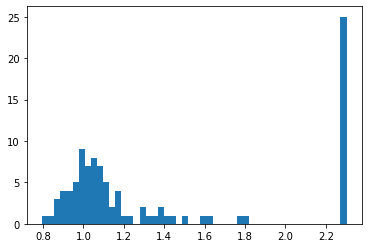

In [12]:
plt.hist(losses_train[:, -1, -1], bins=50);

In [9]:
from sklearn.manifold import TSNE
x = params.reshape(-1, 130)
xe = TSNE(n_components=2).fit_transform(x)
xe = xe.reshape(*params.shape[:-1], 2)
xe.shape

(100, 60, 2)

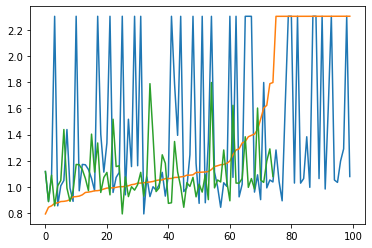

In [18]:
success_mask = losses_train[:, 0, -1]<2.0
plt.plot(losses_train[:, 0, -1])
plt.plot(np.sort(losses_train[:, 0, -1]))
plt.plot(losses_train[success_mask, 0, -1])

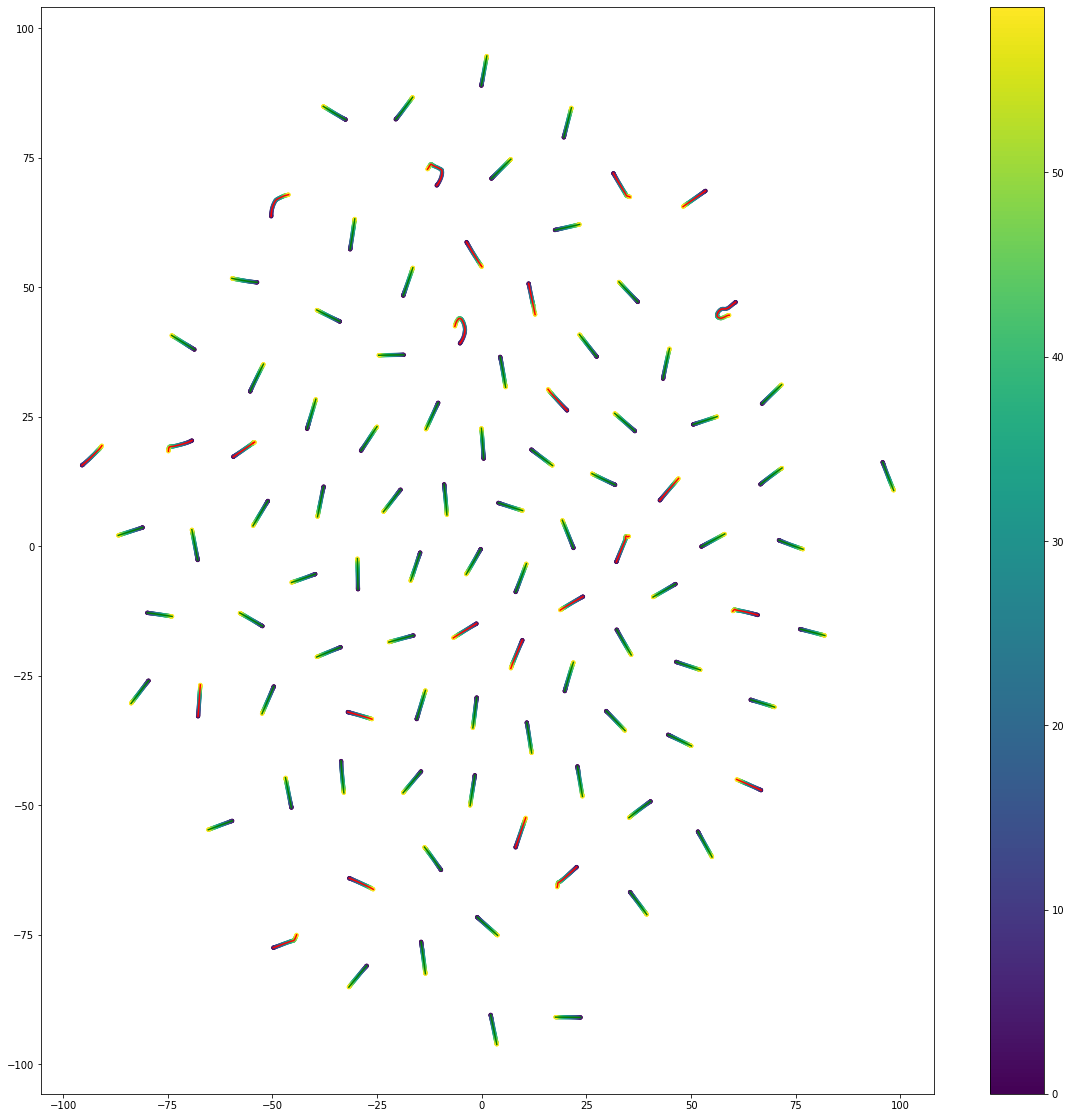

In [12]:
plt.figure(figsize=(20, 20))
for xei in xe[success_mask]:
    plt.scatter(*xei.T, c=np.arange(len(xei)), s=10)
    plt.plot(*xei.T, c='g')
for xei in xe[~success_mask]:
    plt.scatter(*xei.T, c=np.arange(len(xei)), s=10)
    plt.plot(*xei.T, c='r')
plt.colorbar();

In [10]:
params[success_mask, -20:, :].shape

(75, 20, 130)

In [19]:
class NetworkDataset(torch.utils.data.Dataset):
    def __init__(self, n_agents, train=True):
        super().__init__()
        self.n_agents = n_agents
        self.params = params[success_mask, -20:, :].reshape(-1, 130)
        self.losses = losses_train[success_mask, 0, -20:].reshape(-1)
        self.train = train
        if self.train:
            self.params = self.params[5:]
            self.losses = self.losses[5:]
        else:
            self.params = self.params[:5]
            self.losses = self.losses[:5]
    def __len__(self):
        return 10000 if self.train else 100
    def __getitem__(self, idx):
        idx = np.random.choice(len(self.params), size=(self.n_agents,), replace=False)
        return torch.from_numpy(self.params[idx]), torch.from_numpy(self.losses[idx])
        

In [20]:
ds_net = NetworkDataset(3)
dl_net = torch.utils.data.DataLoader(ds_net, batch_size=1000, num_workers=0)
ds_net_test = NetworkDataset(3, train=False)
dl_net_test = torch.utils.data.DataLoader(ds_net_test, batch_size=100, num_workers=0)

In [21]:
for x, y in dl_net:
    print(x.shape, y.shape)
for x, y in dl_net_test:
    print(x.shape, y.shape)

torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([1000, 3, 130]) torch.Size([1000, 3])
torch.Size([100, 3, 130]) torch.Size([100, 3])


In [22]:
def modelgrad2vec(model):
    return torch.cat([p.grad.flatten() for p in model.parameters()])

In [23]:
def calc_loss_grad_vec(v, net, x, y):
    net = util.vec2model(v, net)
    for p in net.parameters():
        if p.grad is not None:
            p.grad.zero_()
    yp = net(x)
    loss = loss_fn(yp, y)
    loss.backward()

    return loss.item(), modelgrad2vec(net)

def batch_calc_loss_grad_vec(vs, net, x, y):
    losses, grads = [], []
    for v in vs:
        loss, grad = calc_loss_grad_vec(v, net, x, y)
        losses.append(loss)
        grads.append(grad)
    vs_copy = vs.detach().clone().requires_grad_()
    torch.cosine_similarity(vs_copy[None], vs_copy[:, None], dim=-1).mean().backward()
    return torch.tensor(losses), torch.stack(grads), vs_copy.grad

In [24]:
x, y = next(iter(dl_train))
x, y = x.to(device), y.to(device)

In [26]:
# v = torch.randn(130).to(device)/4.
v = torch.from_numpy(params[1, -1, :]).to(device)
loss, grad = calc_loss_grad_vec(v, net, x, y)
print(loss, grad.norm().item())
print(losses_train[1, 0, -1])

0.9730967283248901 0.7313293218612671
0.8899707794189453


/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [25]:
from einops.layers.torch import Rearrange

In [27]:
class CONetConvexComb(nn.Module):
    def __init__(self, fill_value=0.):
        super().__init__()
        self.t = nn.Parameter(torch.full((1,), fill_value))
    def forward(self, x):
        # b, 2, 130
        return self.t*x[:, 0, :] + (1-self.t)*x[:, 1, :]

def CONetLinear(init_first=True):
    net = nn.Sequential(
        Rearrange('b k w -> b (k w)'),
        nn.Linear(3*130, 130, bias=False),
    )
    if init_first:
        net[1].weight.data.zero_()
        if net[1].bias is not None:
            net[1].bias.data.zero_()
        net[1].weight.data[:, :130] = 1/3.*torch.eye(130).to(net[1].weight.data)
        net[1].weight.data[:, 130:260] = 1/3.*torch.eye(130).to(net[1].weight.data)
        net[1].weight.data[:, 260:] = 1/3.*torch.eye(130).to(net[1].weight.data)
    return net
    

def CONetDeep():
    return nn.Sequential(
        Rearrange('b k w -> b (k w)'),
        nn.Linear(3*130, 6*130), nn.GELU(),
        nn.Linear(6*130, 12*130), nn.GELU(),
        nn.Linear(12*130, 12*130), nn.GELU(),
        nn.Linear(12*130, 12*130), nn.GELU(),
        nn.Linear(12*130, 6*130), nn.GELU(),
        nn.Linear(6*130, 3*130), nn.GELU(),
        nn.Linear(3*130, 1*130), nn.Tanh(),
    )

# conet = CONetConvexComb(0.5)
conet = CONetLinear()
summary(conet, input_size=(1000, 3, 130))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Rearrange: 1-1                         [1000, 390]               --
├─Linear: 1-2                            [1000, 130]               50,700
Total params: 50,700
Trainable params: 50,700
Non-trainable params: 0
Total mult-adds (M): 50.70
Input size (MB): 1.56
Forward/backward pass size (MB): 1.04
Params size (MB): 0.20
Estimated Total Size (MB): 2.80

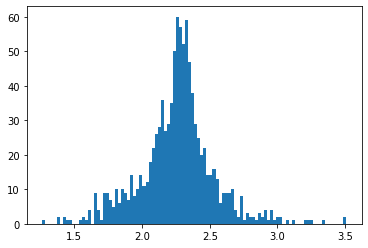

In [28]:
# conet = CONetConvexComb(0.5).to(device)
conet = CONetLinear(init_first=True).to(device)
iw, iwloss = next(iter(dl_net))
iw, iwloss = iw.to(device), iwloss.to(device)
ow = conet(iw)
loss, grad, _ = batch_calc_loss_grad_vec(ow, net, x, y)
plt.hist(loss.cpu().numpy(), bins=100);

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  1.5328469276428223


  0%|          | 0/10 [00:00<?, ?it/s]

2.231135606765747
2.205258369445801
2.2175958156585693
2.220885992050171
2.21157169342041
2.209582567214966
2.182089328765869
2.1600594520568848
2.1284403800964355
2.1076908111572266
input weight distribution
l2    :  5.065468788146973
cossim:  0.056688688695430756
output weight distribution
l2    :  4.092913627624512
cossim:  0.026697296649217606


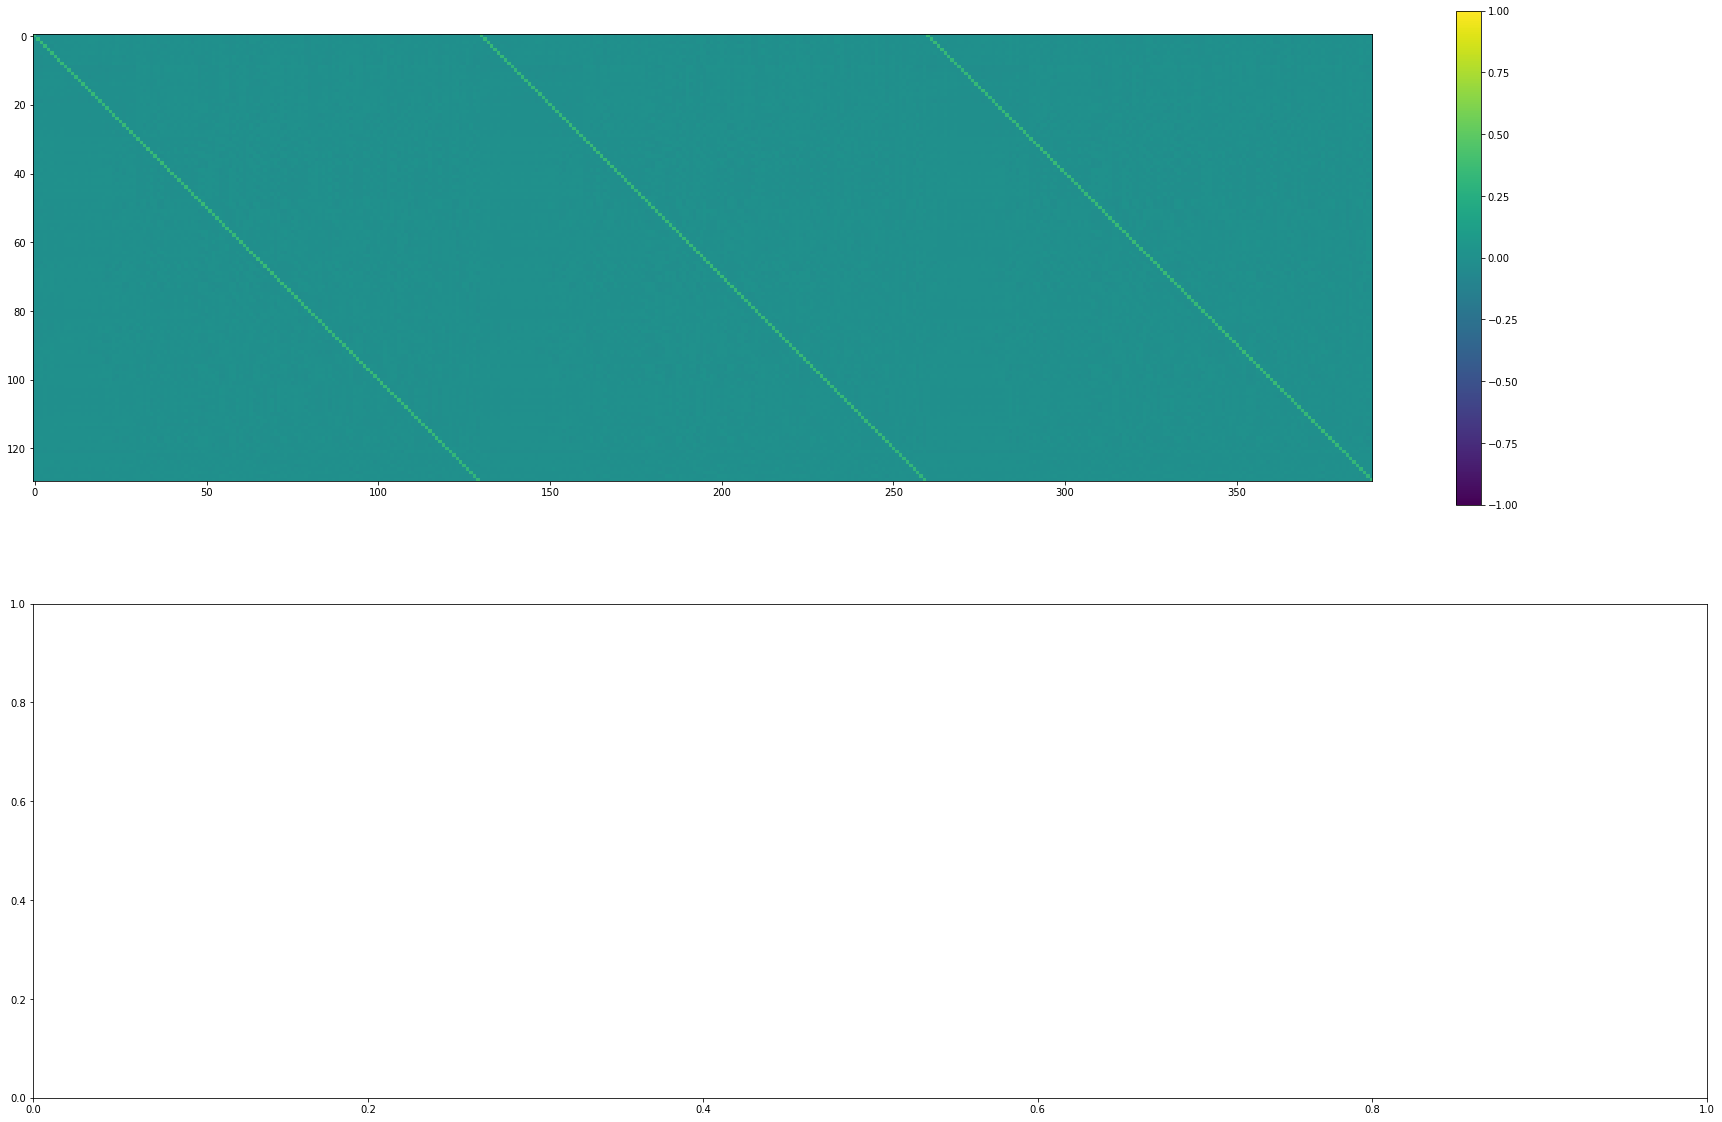

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  2.1185989379882812


  0%|          | 0/10 [00:00<?, ?it/s]

2.066215753555298
2.0407464504241943


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x2b18c362ec18>><bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x2b18c362ec18>><bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x2b18c362ec18>>Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x2b18c362ec18>>Exception ignored in: 
Exception ignored in: 
<bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x2b18c362ec18>>Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 
  Fil

2.007330894470215


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x2b18c362ec18>>
Traceback (most recent call last):
  File "/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/work2/08258/akumar01/maverick2/env/lib64/python3.6/site-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


1.9795112609863281
1.9320334196090698
1.9138673543930054
1.8880668878555298
1.8788765668869019
1.823882818222046
1.830500841140747
input weight distribution
l2    :  5.072457790374756
cossim:  0.05554550886154175
output weight distribution
l2    :  4.993809700012207
cossim:  0.044712040573358536


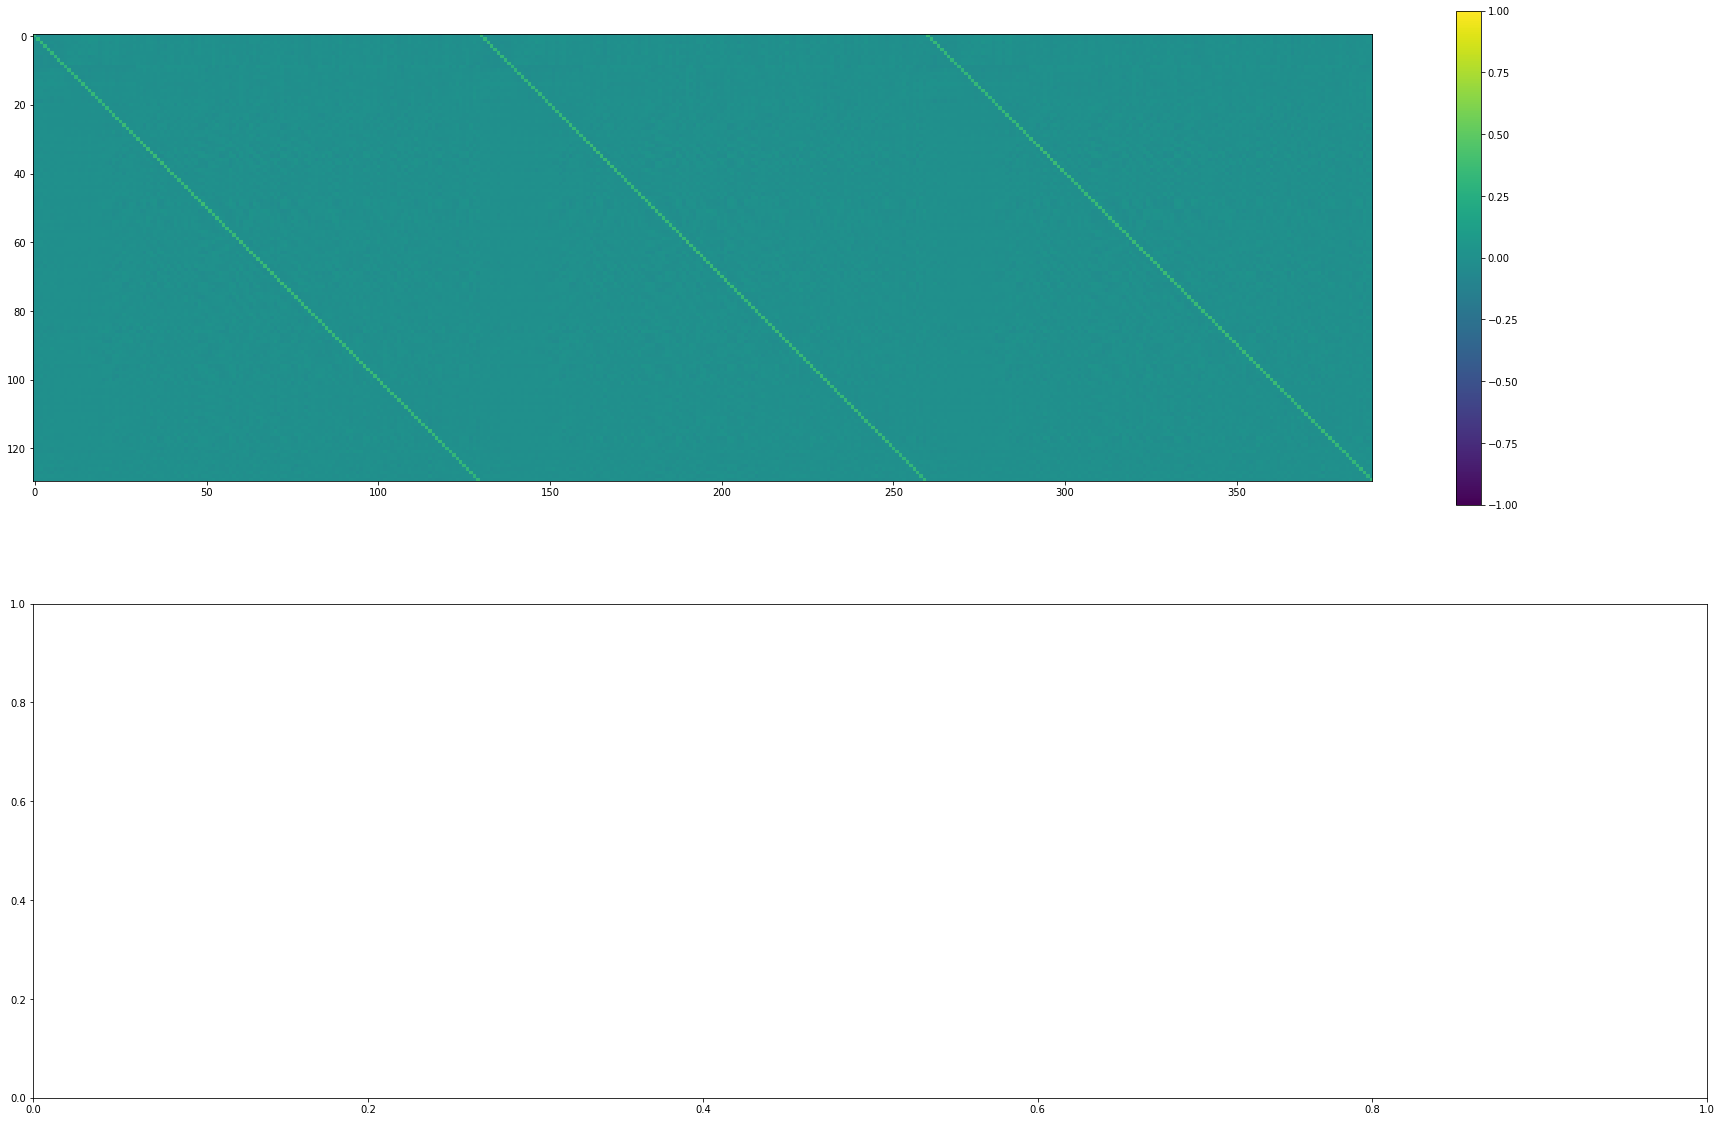

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  2.1886370182037354


  0%|          | 0/10 [00:00<?, ?it/s]

1.8041999340057373
1.7664440870285034
1.7436795234680176
1.697514295578003
1.7051953077316284
1.6676198244094849
1.649185061454773
1.6241799592971802
1.5997049808502197
1.5817039012908936
input weight distribution
l2    :  5.094716548919678
cossim:  0.05367252975702286
output weight distribution
l2    :  5.696927070617676
cossim:  0.047503940761089325


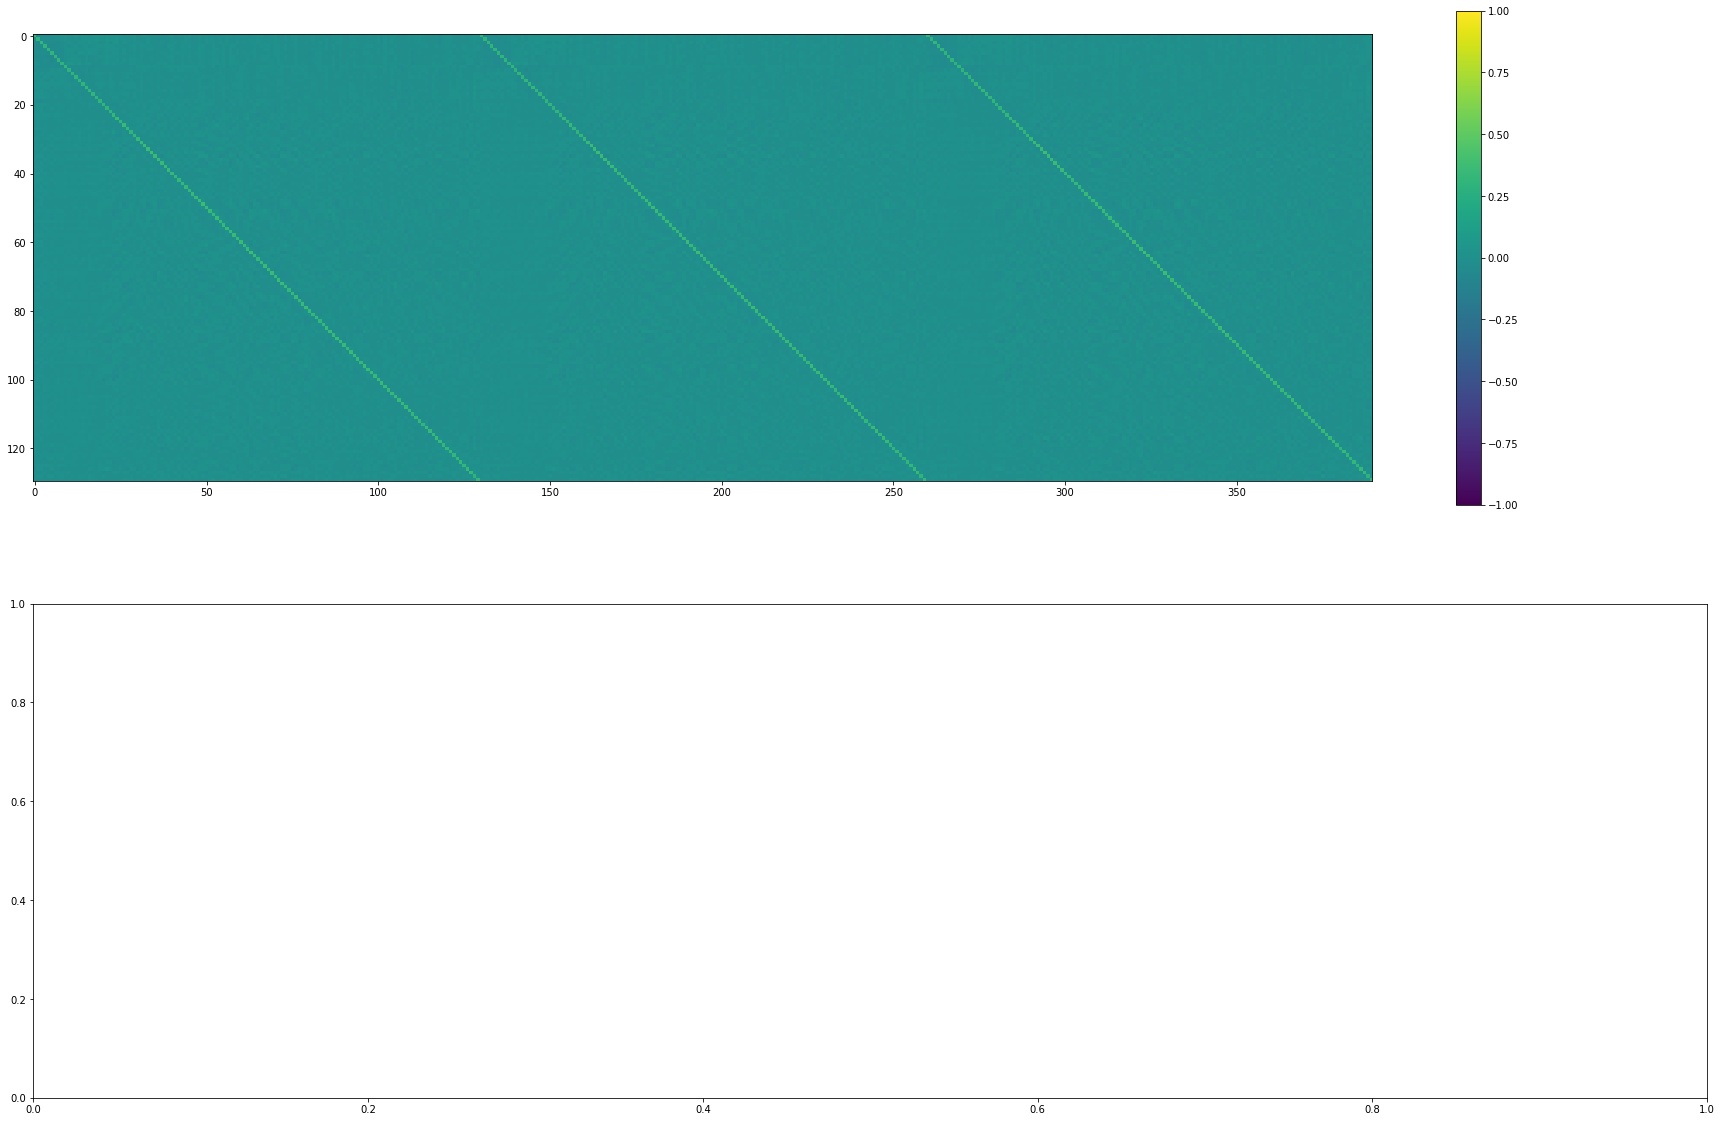

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  2.073566436767578


  0%|          | 0/10 [00:00<?, ?it/s]

1.5628035068511963
1.5455751419067383
1.5229926109313965
1.516878604888916
1.498229742050171
1.4909785985946655
1.4700473546981812
1.4384456872940063
1.4266011714935303
1.4122505187988281
input weight distribution
l2    :  5.091751575469971
cossim:  0.05479808896780014
output weight distribution
l2    :  6.319326400756836
cossim:  0.0526818111538887


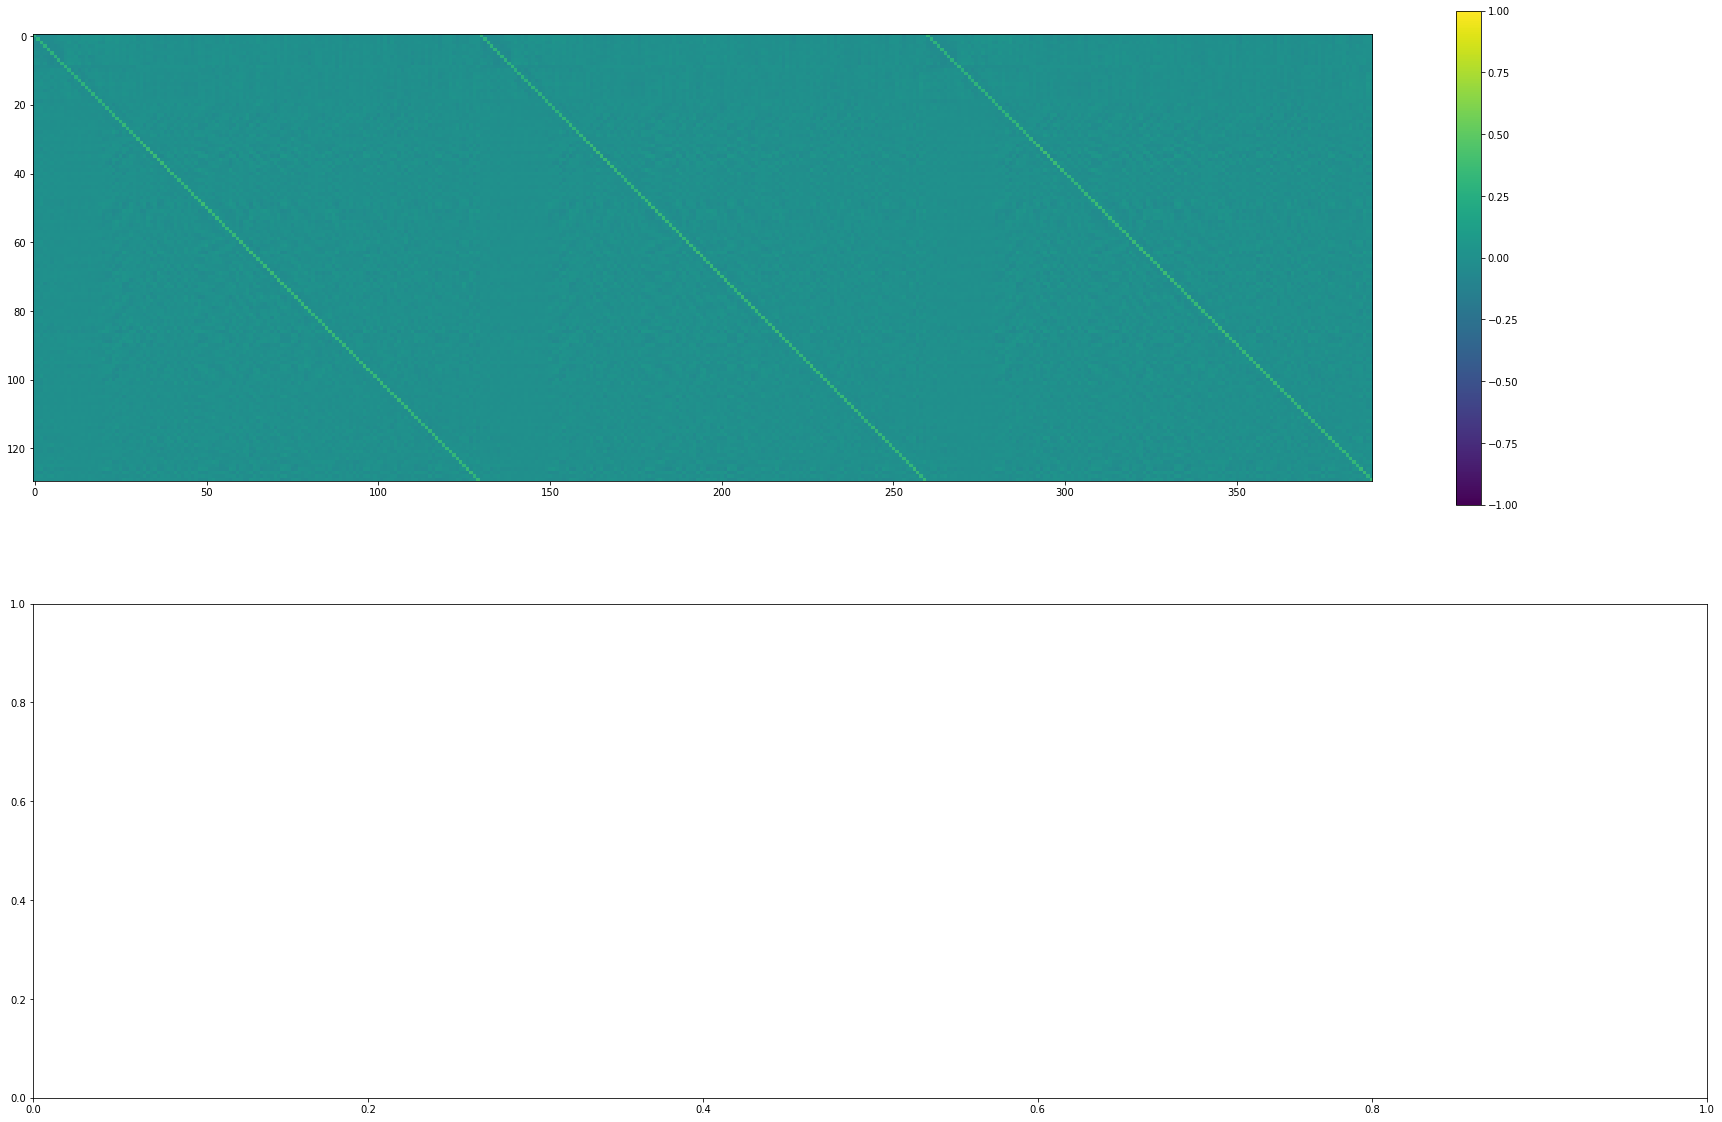

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  1.6703236103057861


  0%|          | 0/10 [00:00<?, ?it/s]

1.397505521774292
1.3817936182022095
1.3745378255844116
1.3863637447357178
1.3723456859588623
1.3586913347244263
1.3551528453826904
1.3242236375808716
1.3119595050811768
1.3109476566314697
input weight distribution
l2    :  5.069797039031982
cossim:  0.054595425724983215
output weight distribution
l2    :  7.123180866241455
cossim:  0.045009221881628036


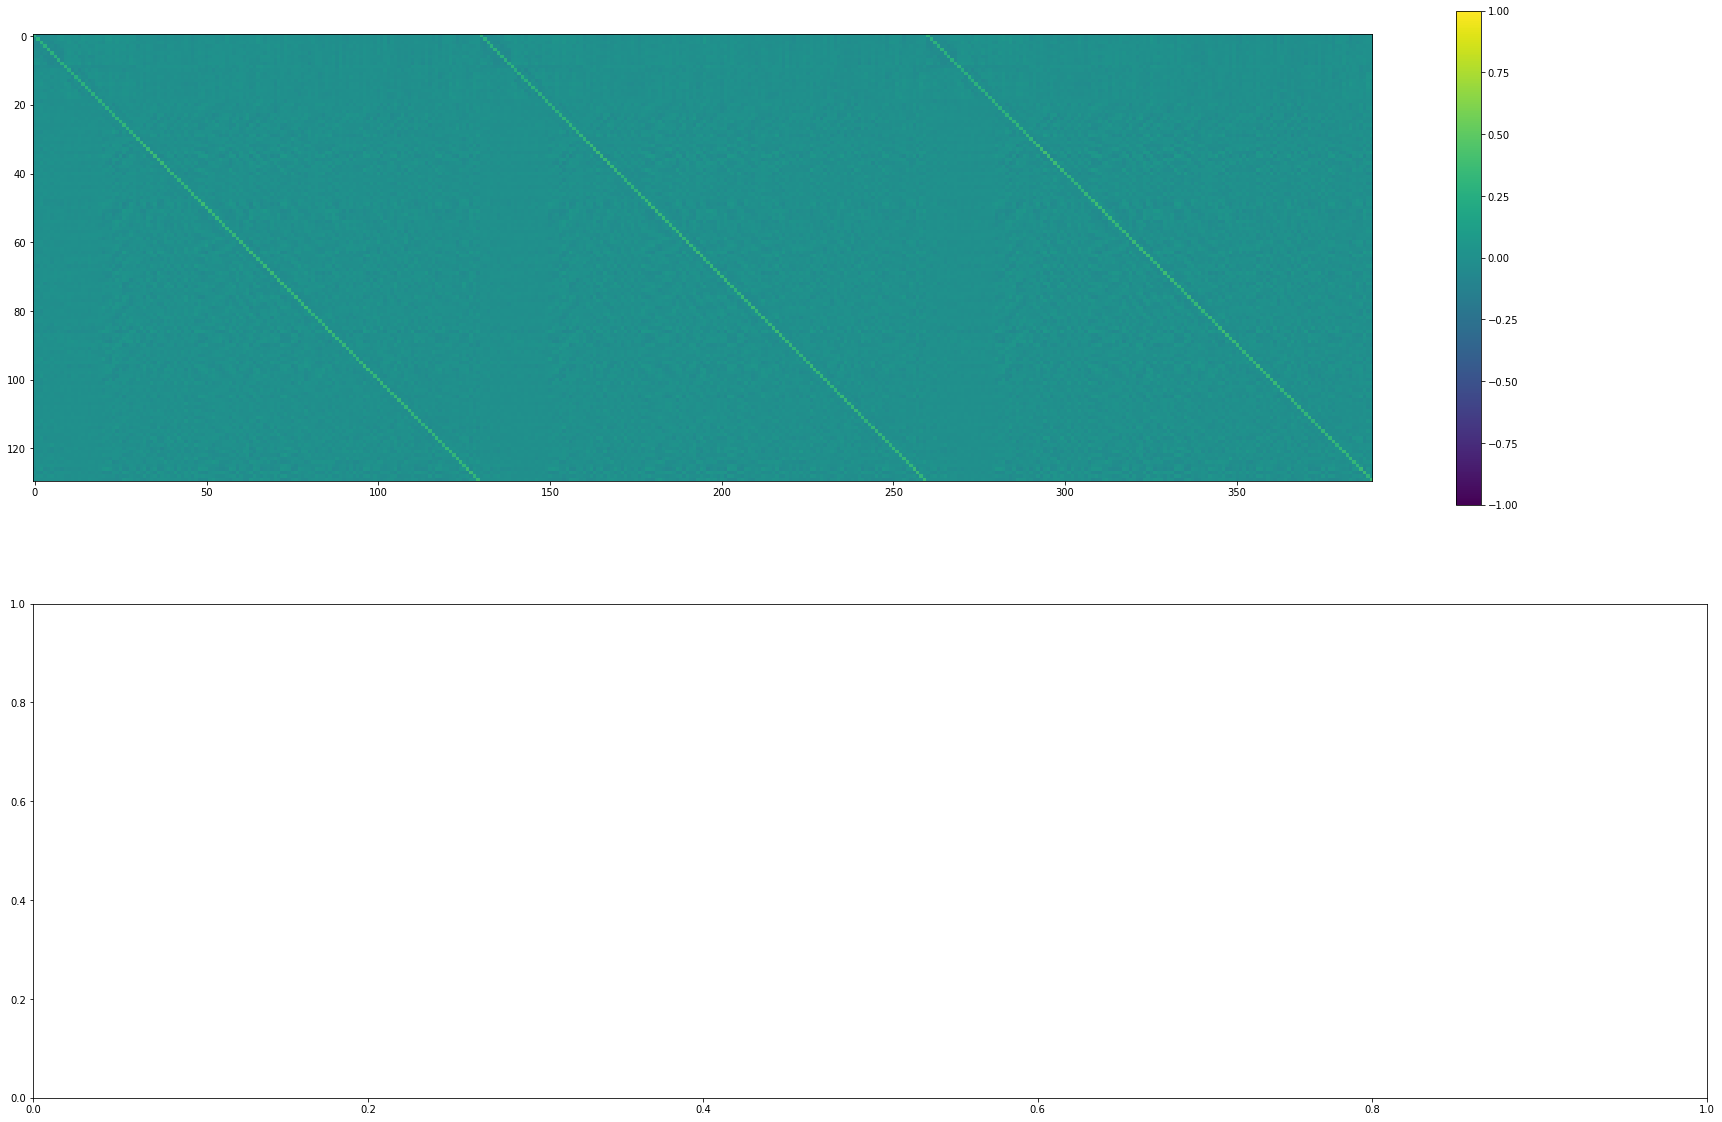

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  1.3448138236999512


  0%|          | 0/10 [00:00<?, ?it/s]

1.318973183631897
1.2980173826217651
1.302093505859375
1.2845860719680786
1.2806522846221924
1.2780582904815674
1.2628470659255981
1.266348958015442
1.2422040700912476
1.247198462486267
input weight distribution
l2    :  5.060304641723633
cossim:  0.05727985128760338
output weight distribution
l2    :  7.757291316986084
cossim:  0.039681315422058105


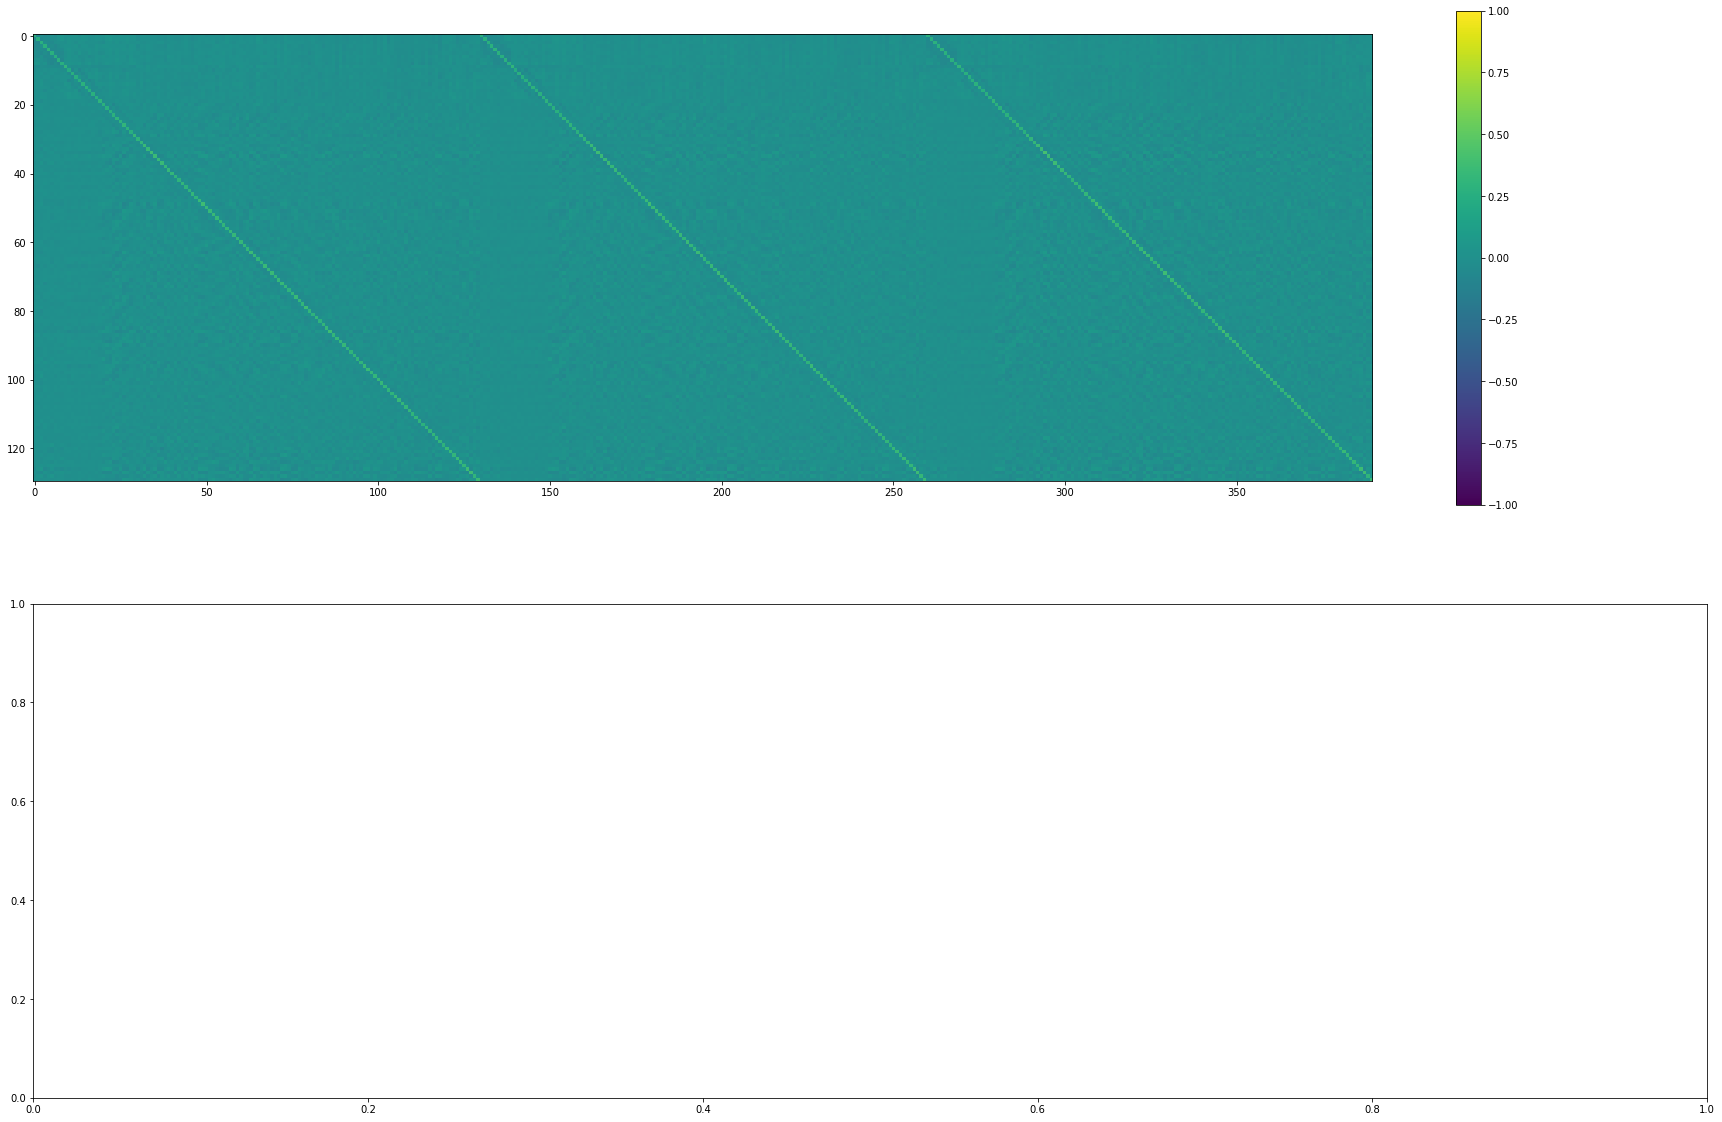

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  1.3007006645202637


  0%|          | 0/10 [00:00<?, ?it/s]

1.2608046531677246
1.2430968284606934
1.2477552890777588
1.2281968593597412
1.212592363357544
1.2179313898086548
1.2305748462677002
1.2293599843978882
1.2202917337417603
1.2099018096923828
input weight distribution
l2    :  5.063579082489014
cossim:  0.05506443977355957
output weight distribution
l2    :  8.45421314239502
cossim:  0.03523329645395279


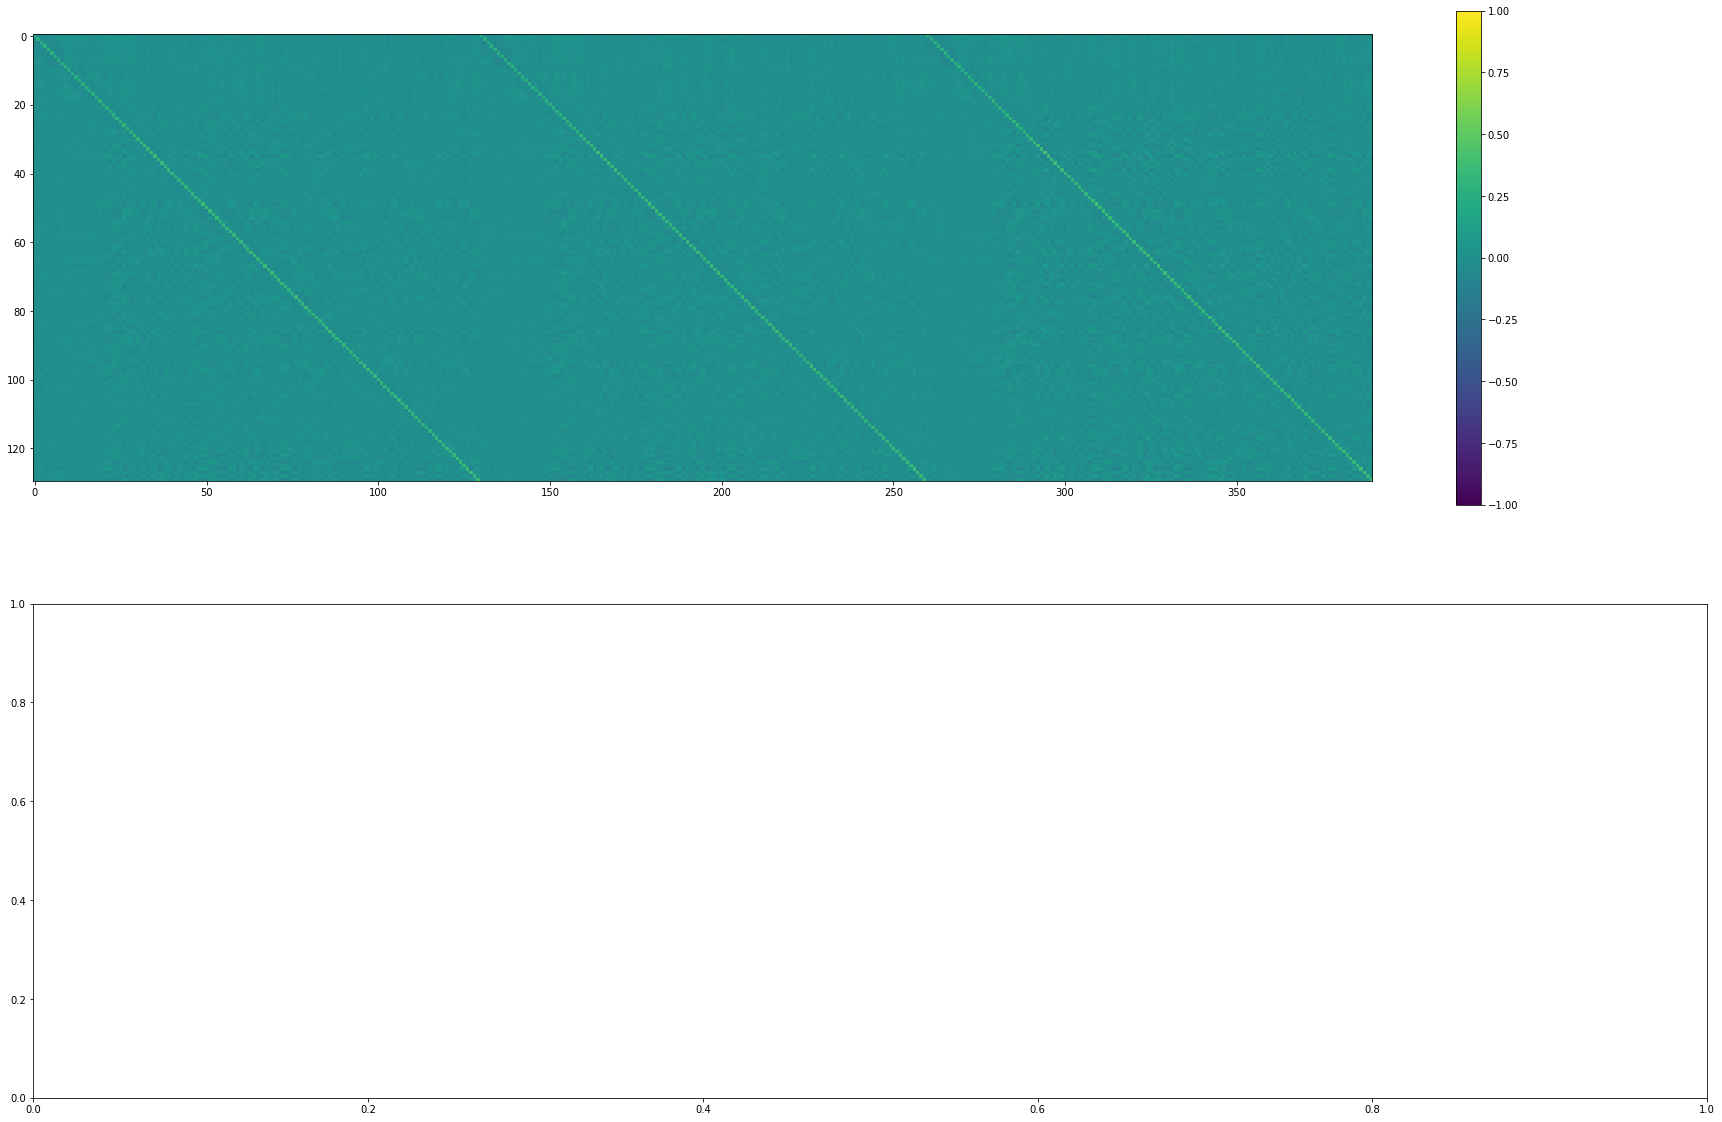

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  1.234833836555481


  0%|          | 0/10 [00:00<?, ?it/s]

1.19845449924469
1.2061805725097656
1.188225507736206
1.1877243518829346
1.1954553127288818
1.1974337100982666
1.1777384281158447
1.1728168725967407
1.1725527048110962
1.1674669981002808
input weight distribution
l2    :  5.063380718231201
cossim:  0.057516563683748245
output weight distribution
l2    :  8.988136291503906
cossim:  0.037316273897886276


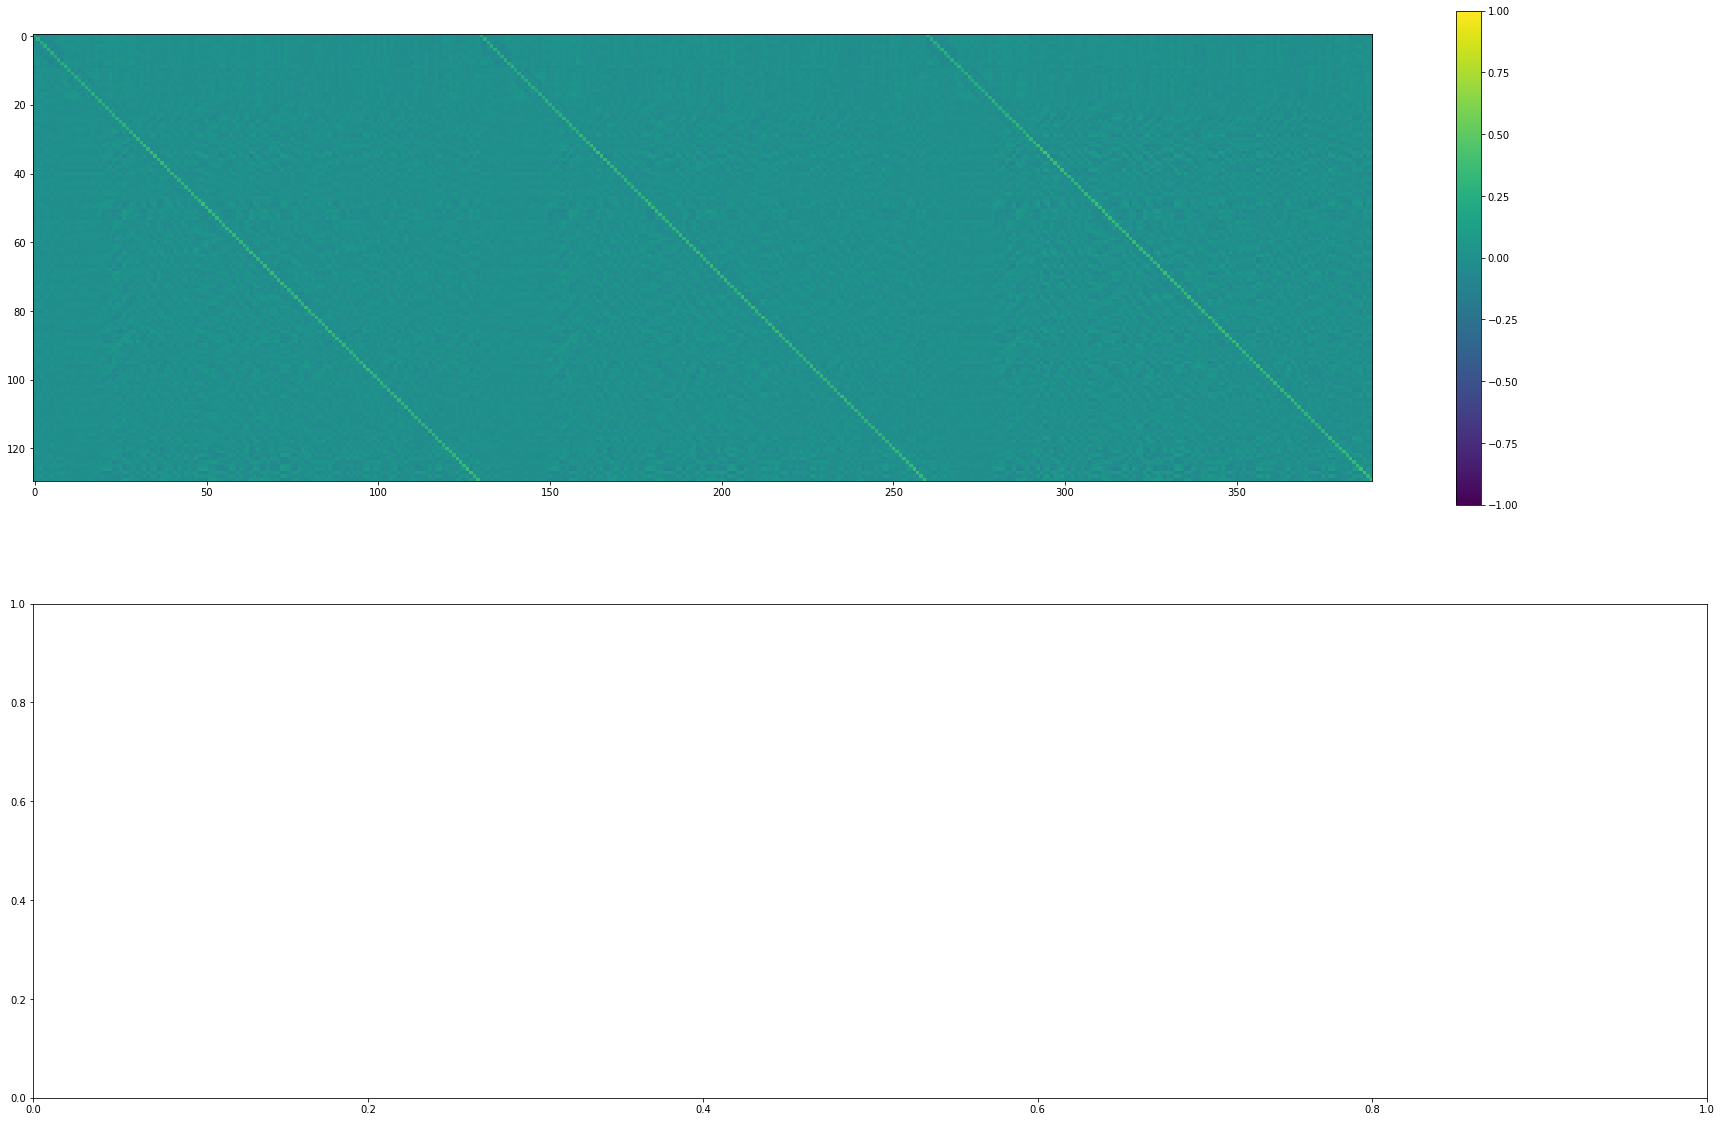

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  1.0651379823684692


  0%|          | 0/10 [00:00<?, ?it/s]

1.159187912940979
1.1448566913604736
1.1417722702026367
1.1563618183135986
1.1448450088500977
1.1395039558410645
1.1349623203277588
1.1230733394622803
1.1215319633483887
1.1152546405792236
input weight distribution
l2    :  5.069393157958984
cossim:  0.05604564771056175
output weight distribution
l2    :  9.440053939819336
cossim:  0.0338631197810173


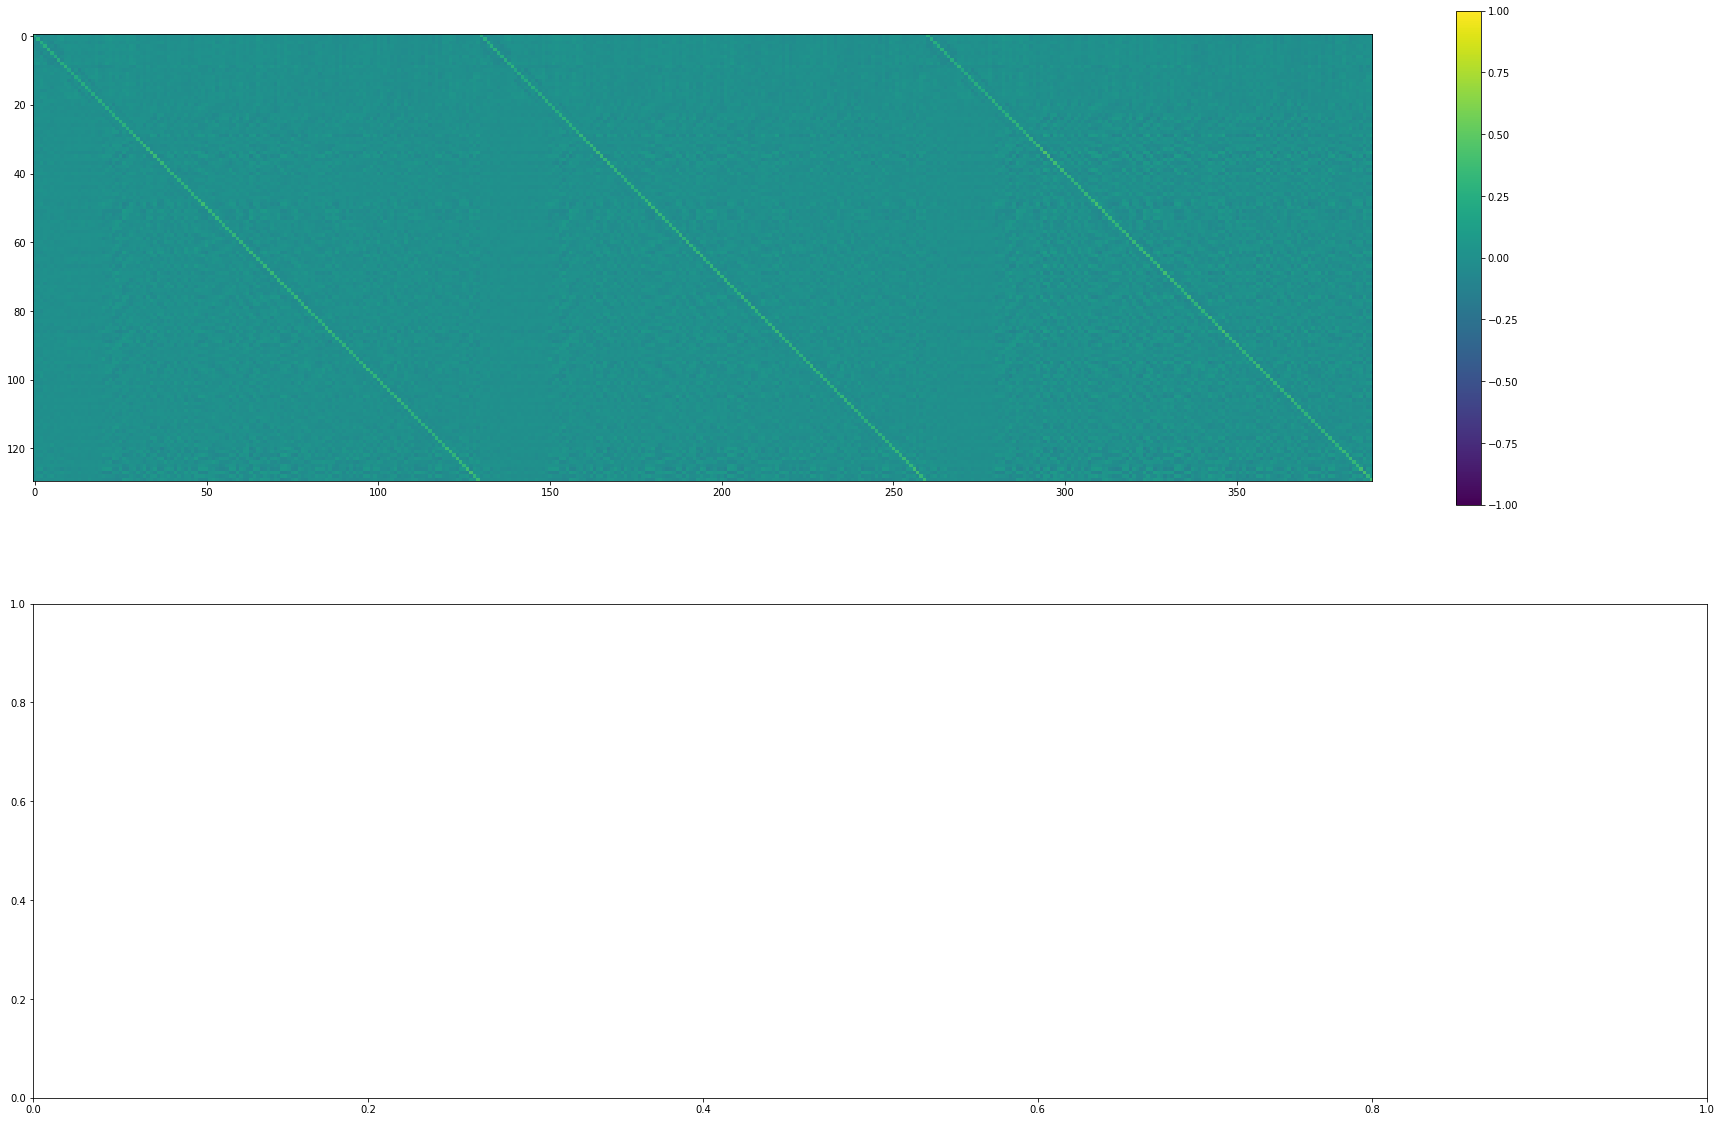

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  1.0910959243774414


  0%|          | 0/10 [00:00<?, ?it/s]

1.1325440406799316
1.1109048128128052
1.1107062101364136
1.103310465812683
1.0910195112228394
1.0899325609207153
1.0991650819778442
1.0765998363494873
1.086605191230774
1.0887665748596191
input weight distribution
l2    :  5.056337833404541
cossim:  0.05657002329826355
output weight distribution
l2    :  9.728754043579102
cossim:  0.031123759225010872


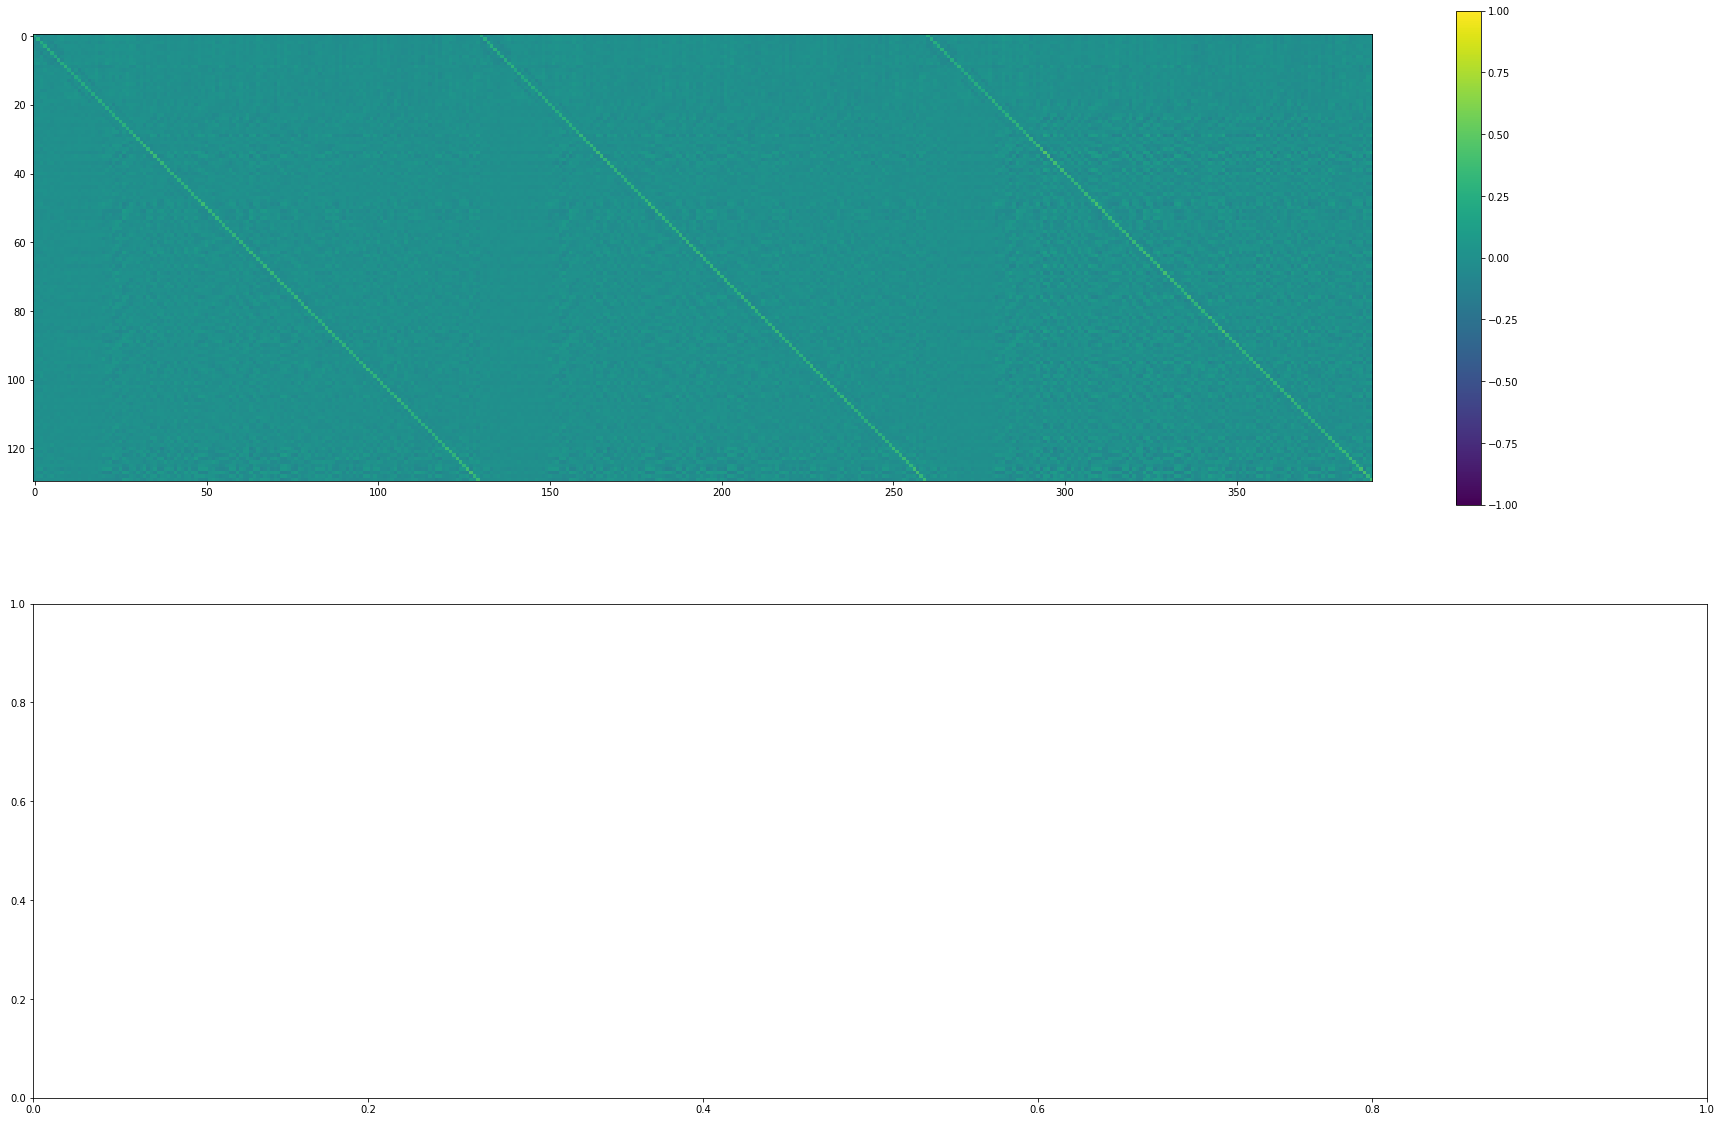

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  1.0345714092254639


  0%|          | 0/10 [00:00<?, ?it/s]

1.0722299814224243
1.0519301891326904
1.0682731866836548
1.0620548725128174
1.054888129234314
1.0282787084579468
1.0300421714782715
1.0299272537231445
1.0277281999588013
1.008104681968689
input weight distribution
l2    :  5.053740978240967
cossim:  0.05508062615990639
output weight distribution
l2    :  10.590620040893555
cossim:  0.03204909339547157


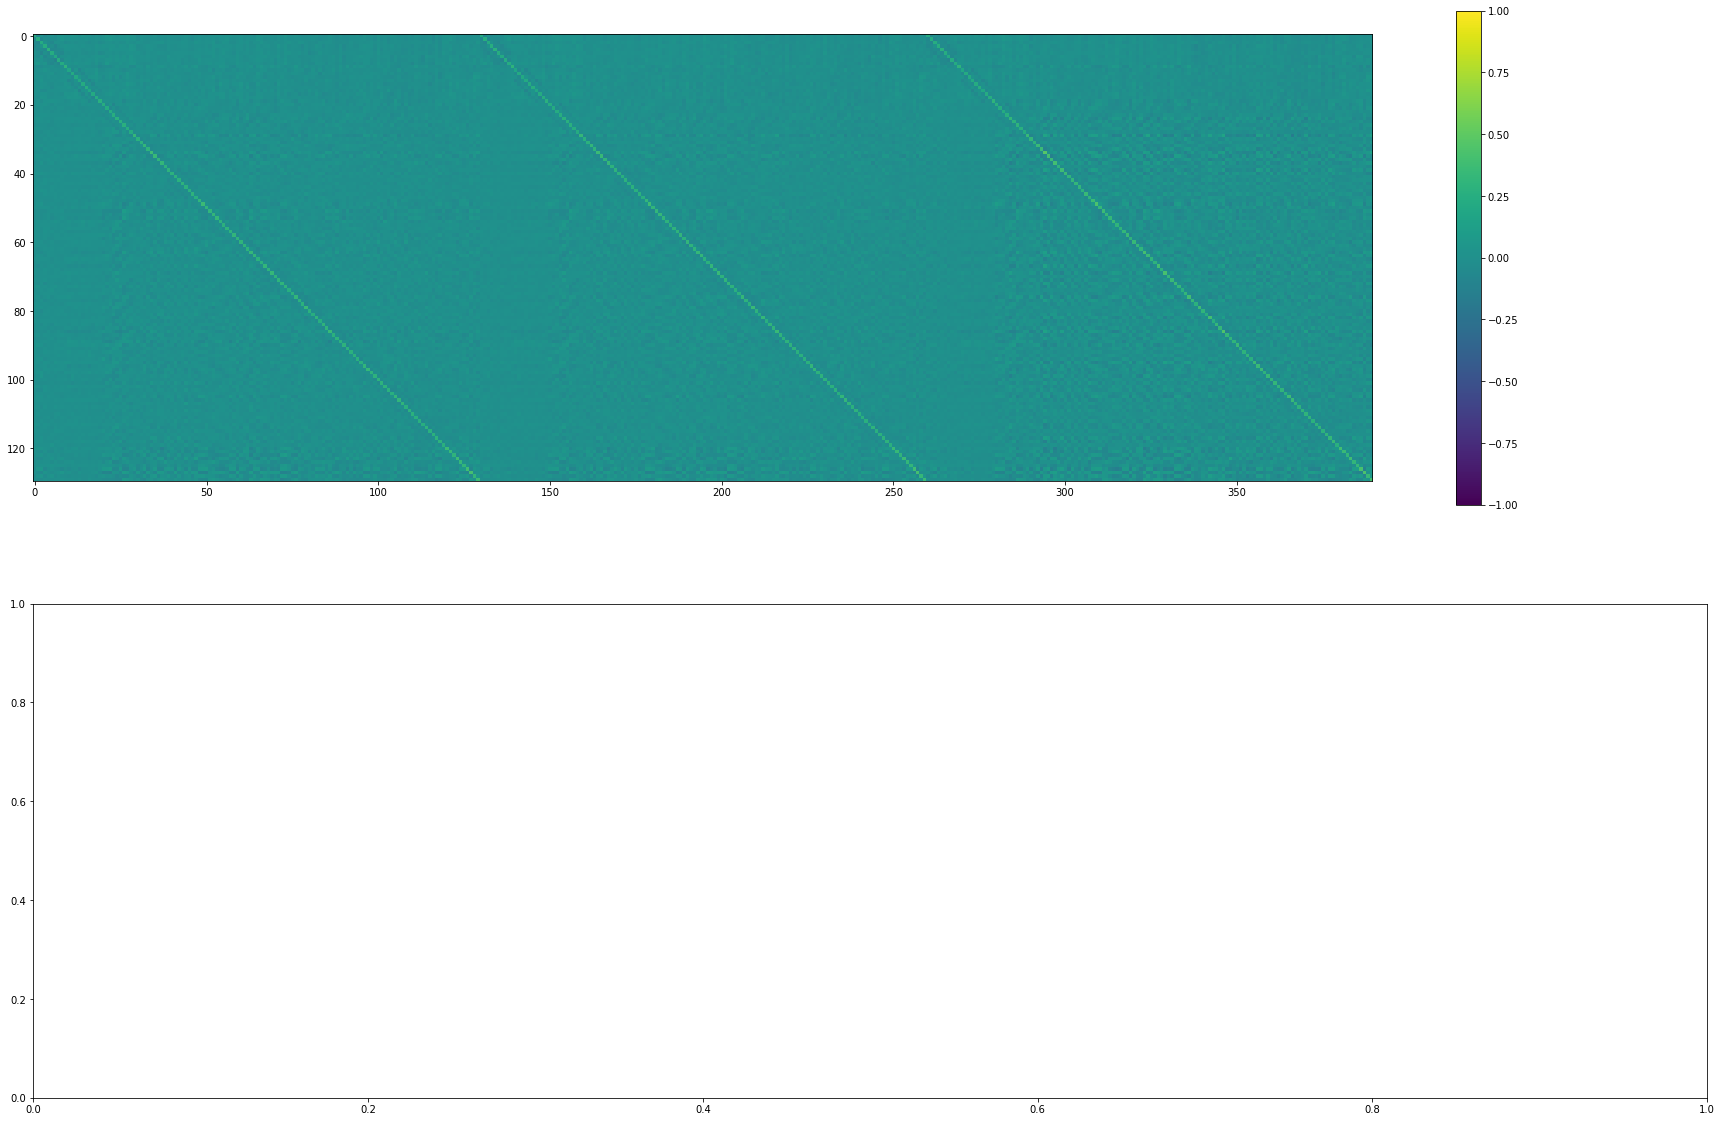

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.997954249382019


  0%|          | 0/10 [00:00<?, ?it/s]

1.0189263820648193
1.021653652191162
1.0059736967086792
1.0072145462036133
1.0087374448776245
0.999875009059906
0.9957398772239685
0.9914796948432922
0.9852842092514038
0.9801092743873596
input weight distribution
l2    :  5.058588981628418
cossim:  0.05544430390000343
output weight distribution
l2    :  10.754125595092773
cossim:  0.027368590235710144


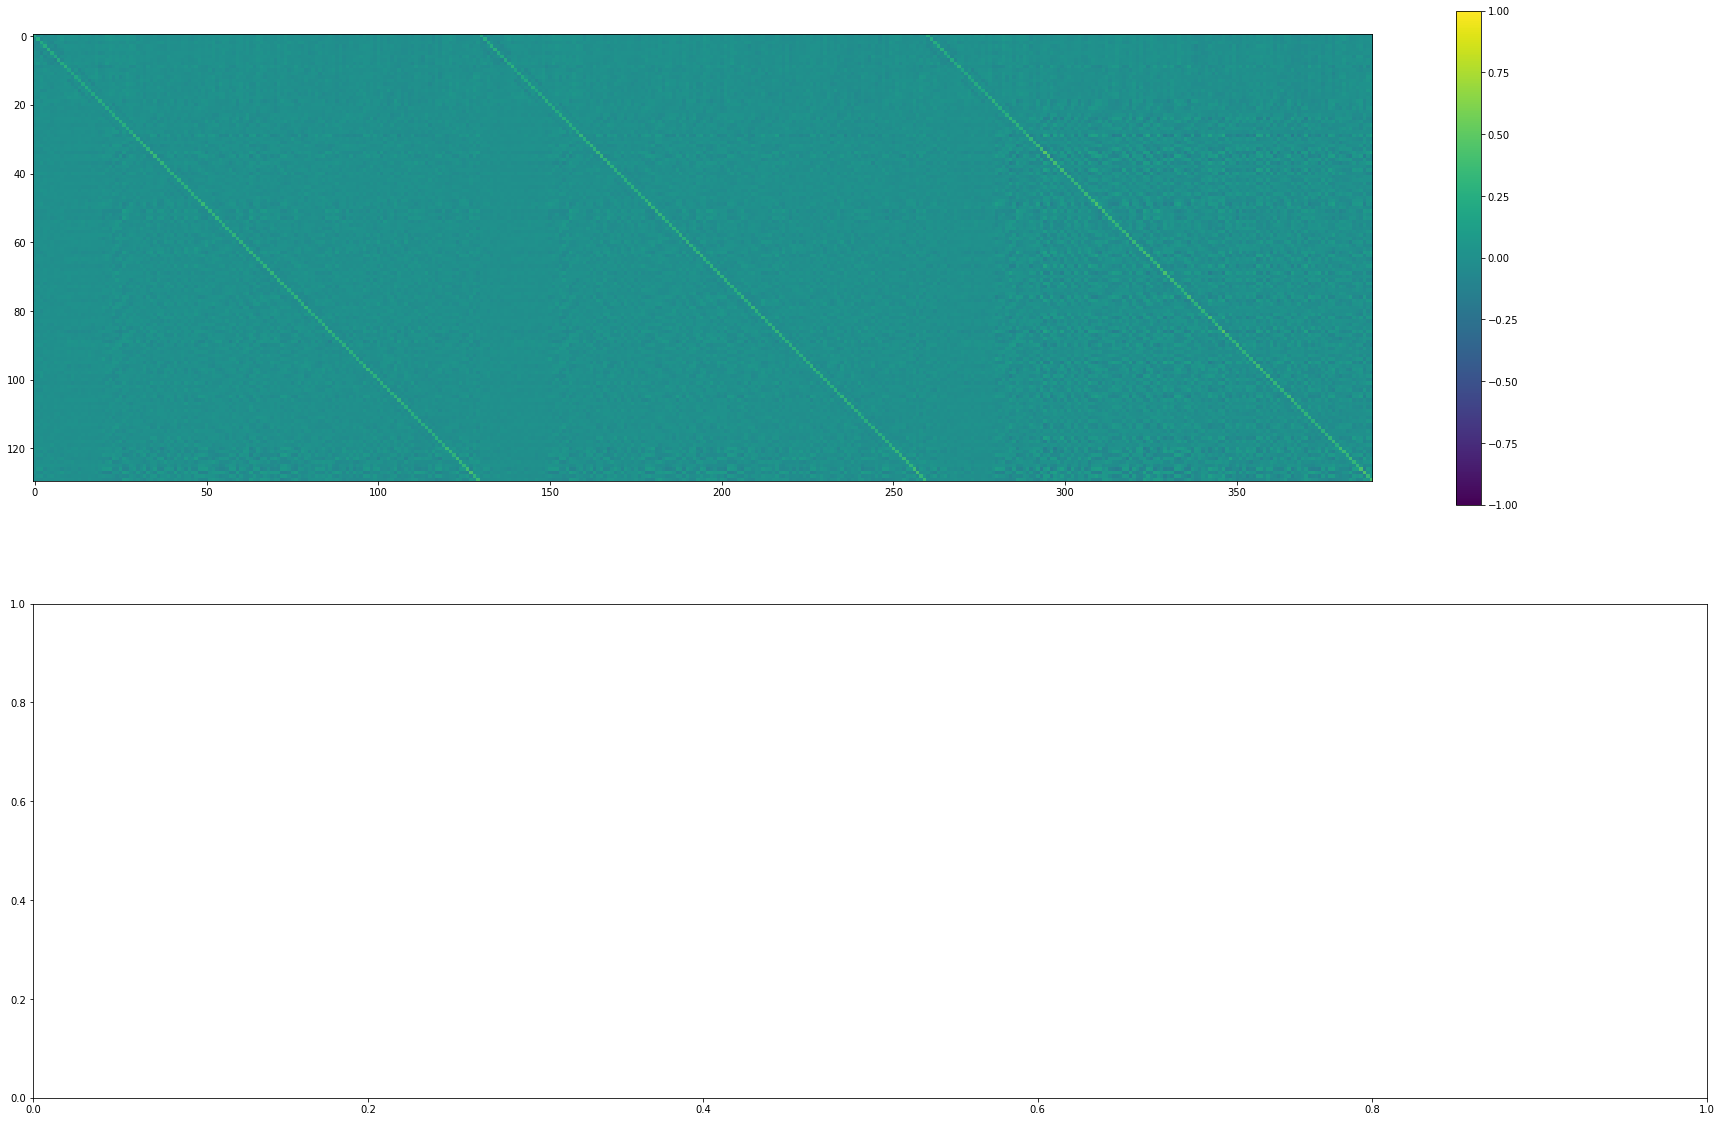

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.9849598407745361


  0%|          | 0/10 [00:00<?, ?it/s]

0.961959183216095
0.9792238473892212
0.9625095725059509
0.9448006749153137
0.9447038173675537
0.9397270083427429
0.9501729011535645
0.9312968850135803
0.9253069162368774
0.9181898236274719
input weight distribution
l2    :  5.053889751434326
cossim:  0.056124601513147354
output weight distribution
l2    :  11.307924270629883
cossim:  0.0302910003811121


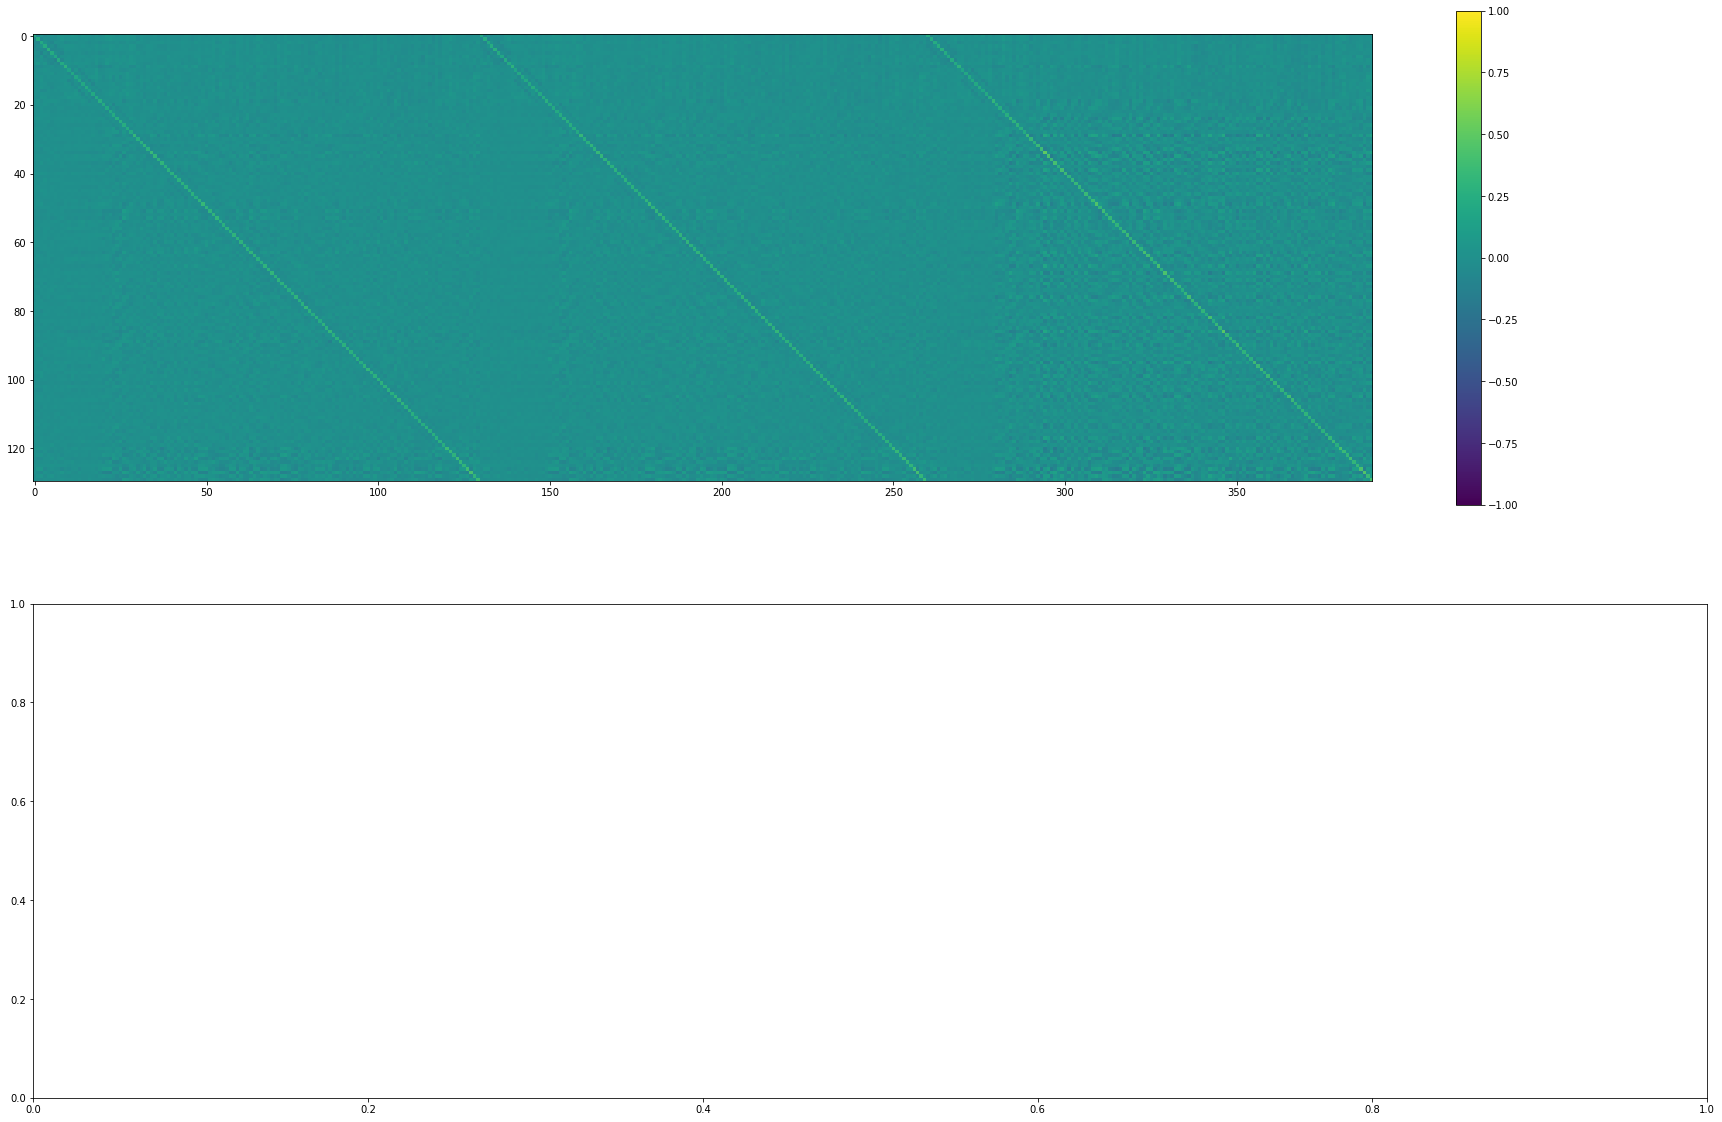

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.9339953660964966


  0%|          | 0/10 [00:00<?, ?it/s]

0.9105733633041382
0.9158146977424622
0.9212483763694763
0.9012094736099243
0.9055508971214294
0.8959959745407104
0.8753013014793396
0.8809608221054077
0.8813203573226929
0.8781074285507202
input weight distribution
l2    :  5.0581231117248535
cossim:  0.0558551624417305
output weight distribution
l2    :  11.506728172302246
cossim:  0.026391543447971344


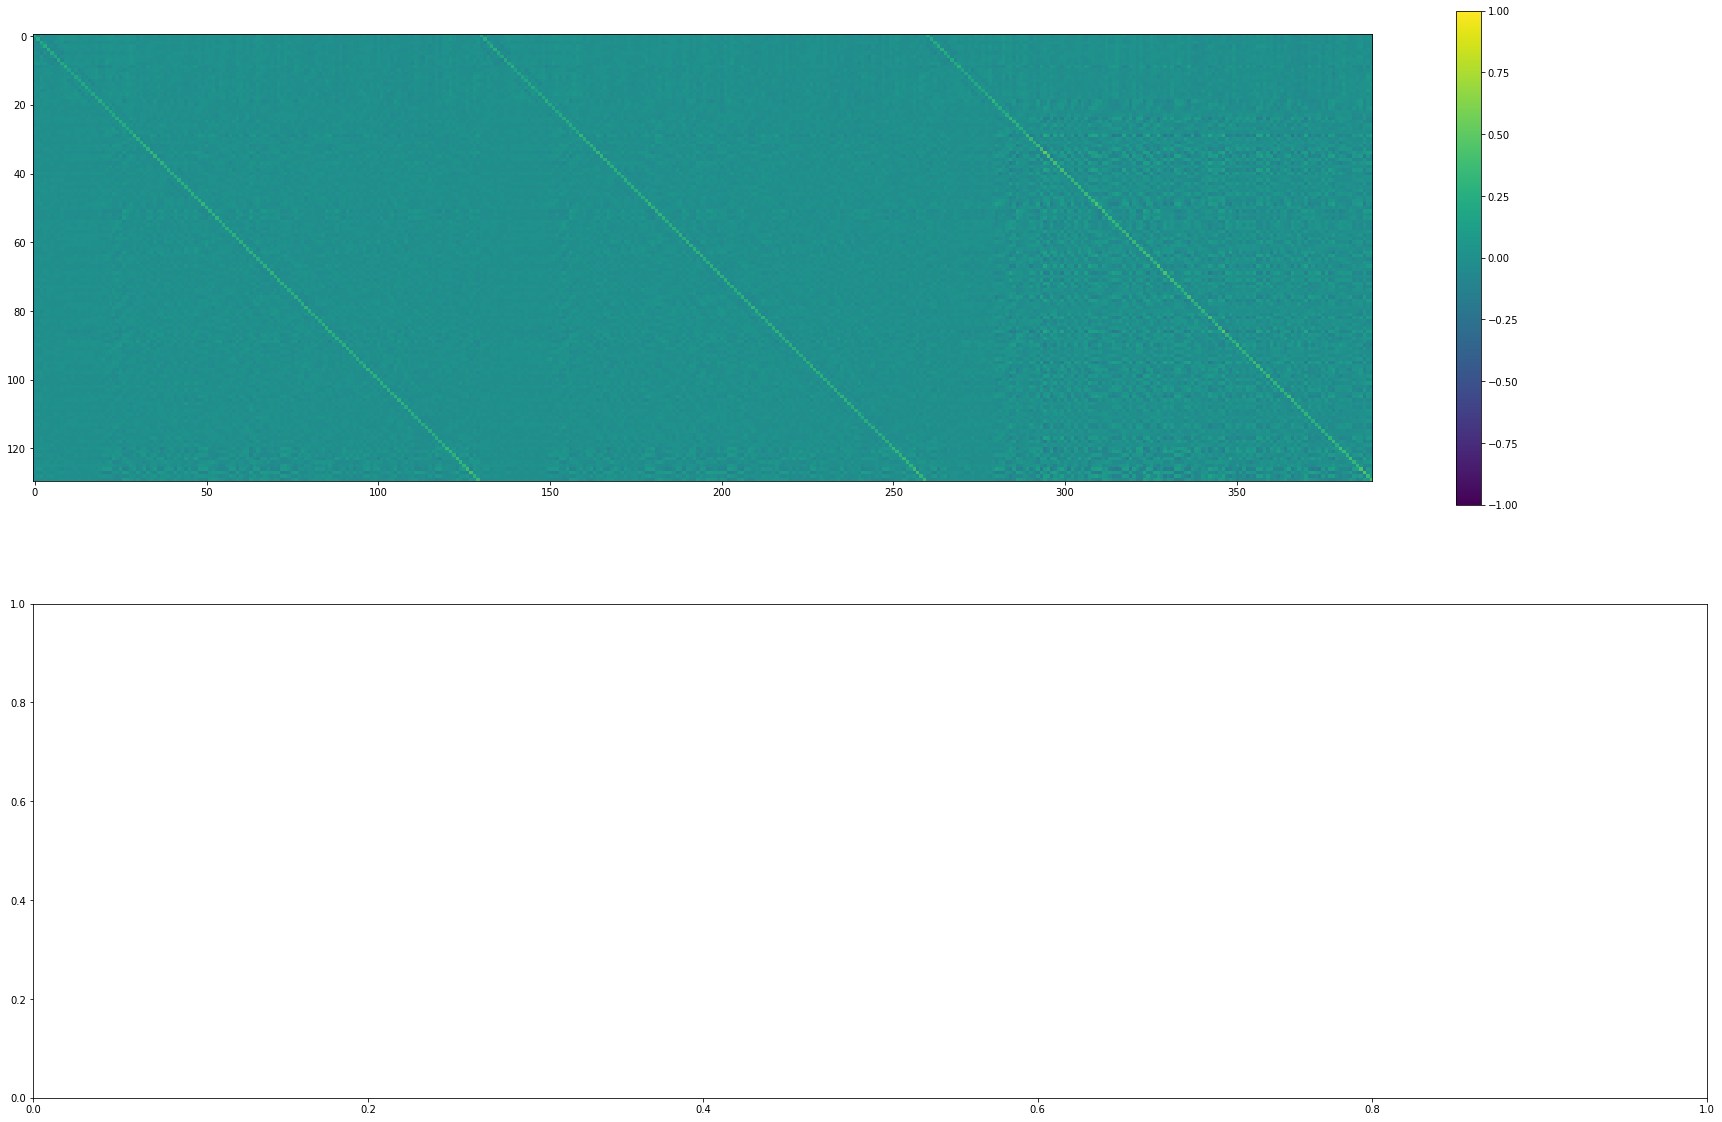

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.9059939384460449


  0%|          | 0/10 [00:00<?, ?it/s]

0.8636539578437805
0.8545187711715698
0.8577390909194946
0.8498651385307312
0.8424907326698303
0.8433467745780945
0.8330144286155701
0.8307518362998962
0.8217717409133911
0.8228394389152527
input weight distribution
l2    :  5.055748462677002
cossim:  0.05535126477479935
output weight distribution
l2    :  11.789470672607422
cossim:  0.03189163655042648


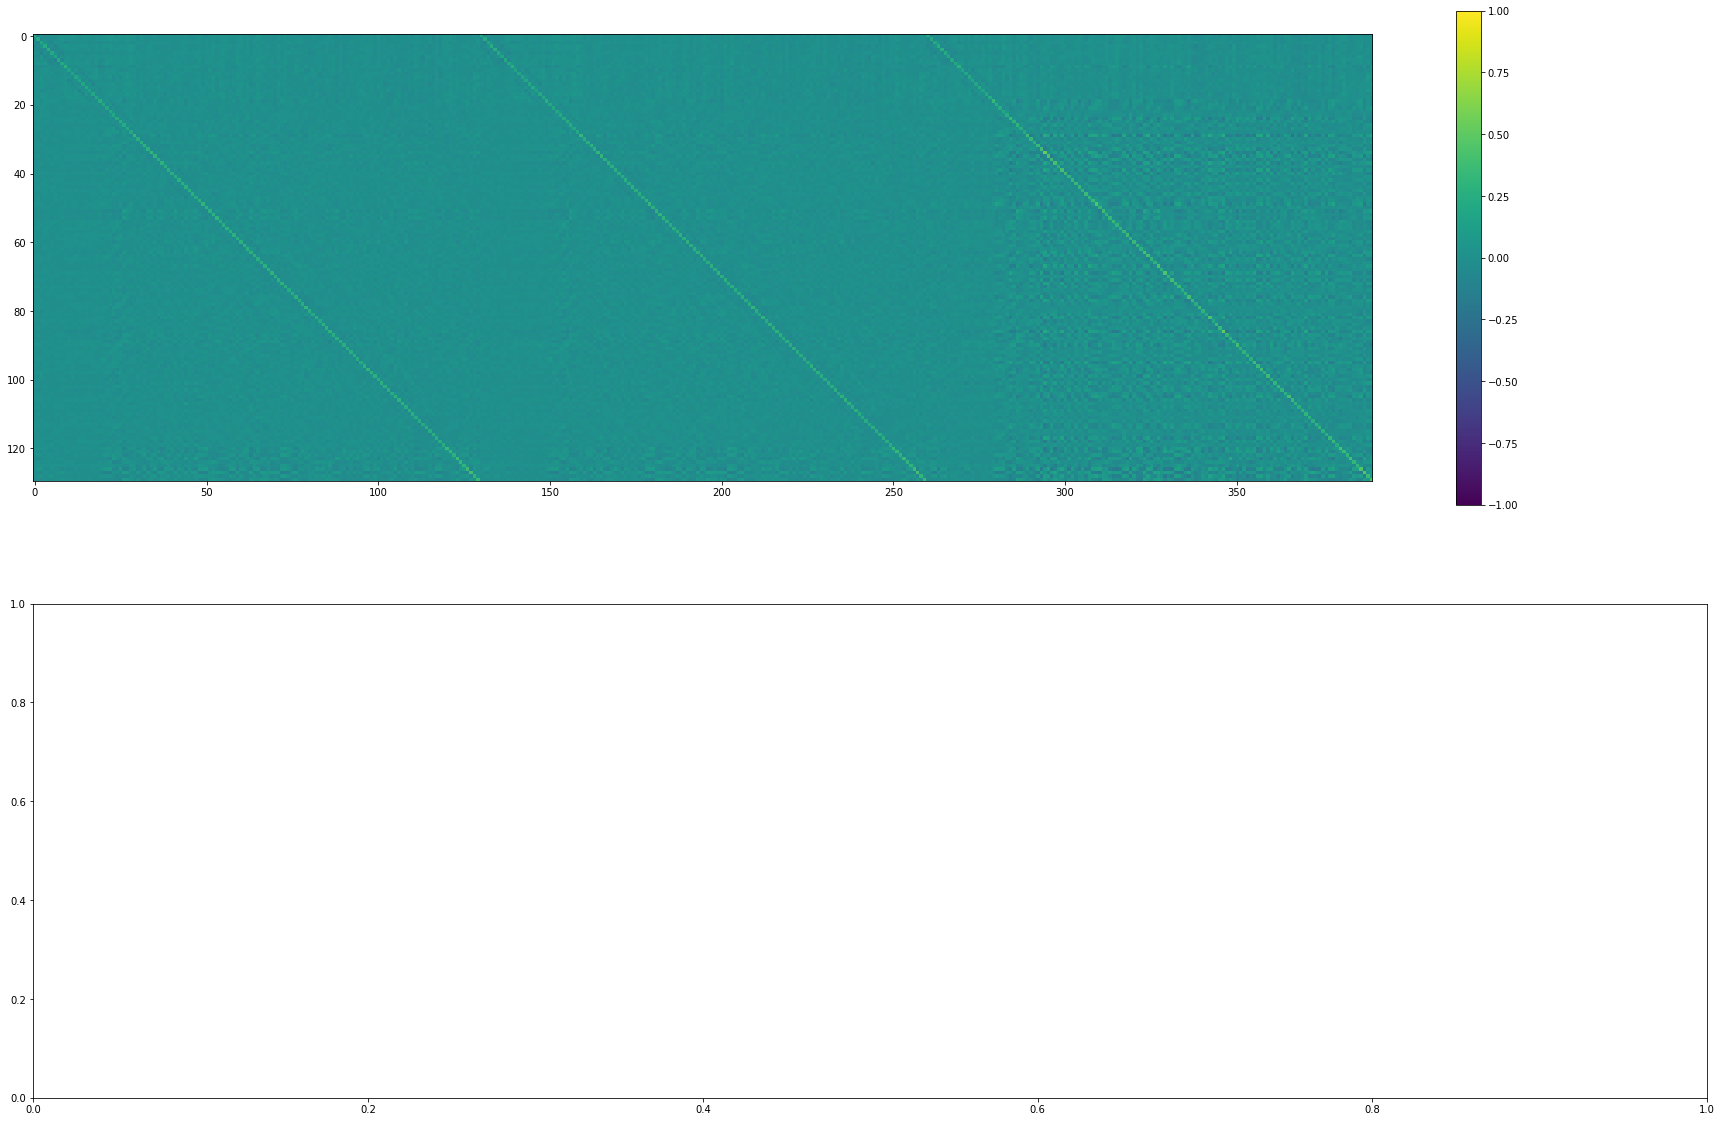

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.8934925198554993


  0%|          | 0/10 [00:00<?, ?it/s]

0.813582181930542
0.8204144835472107
0.8083479404449463
0.8064925670623779
0.7975064516067505
0.7965259552001953
0.7903851270675659
0.792129635810852
0.7737445831298828
0.7837585210800171
input weight distribution
l2    :  5.085691928863525
cossim:  0.05482012778520584
output weight distribution
l2    :  12.176627159118652
cossim:  0.024025117978453636


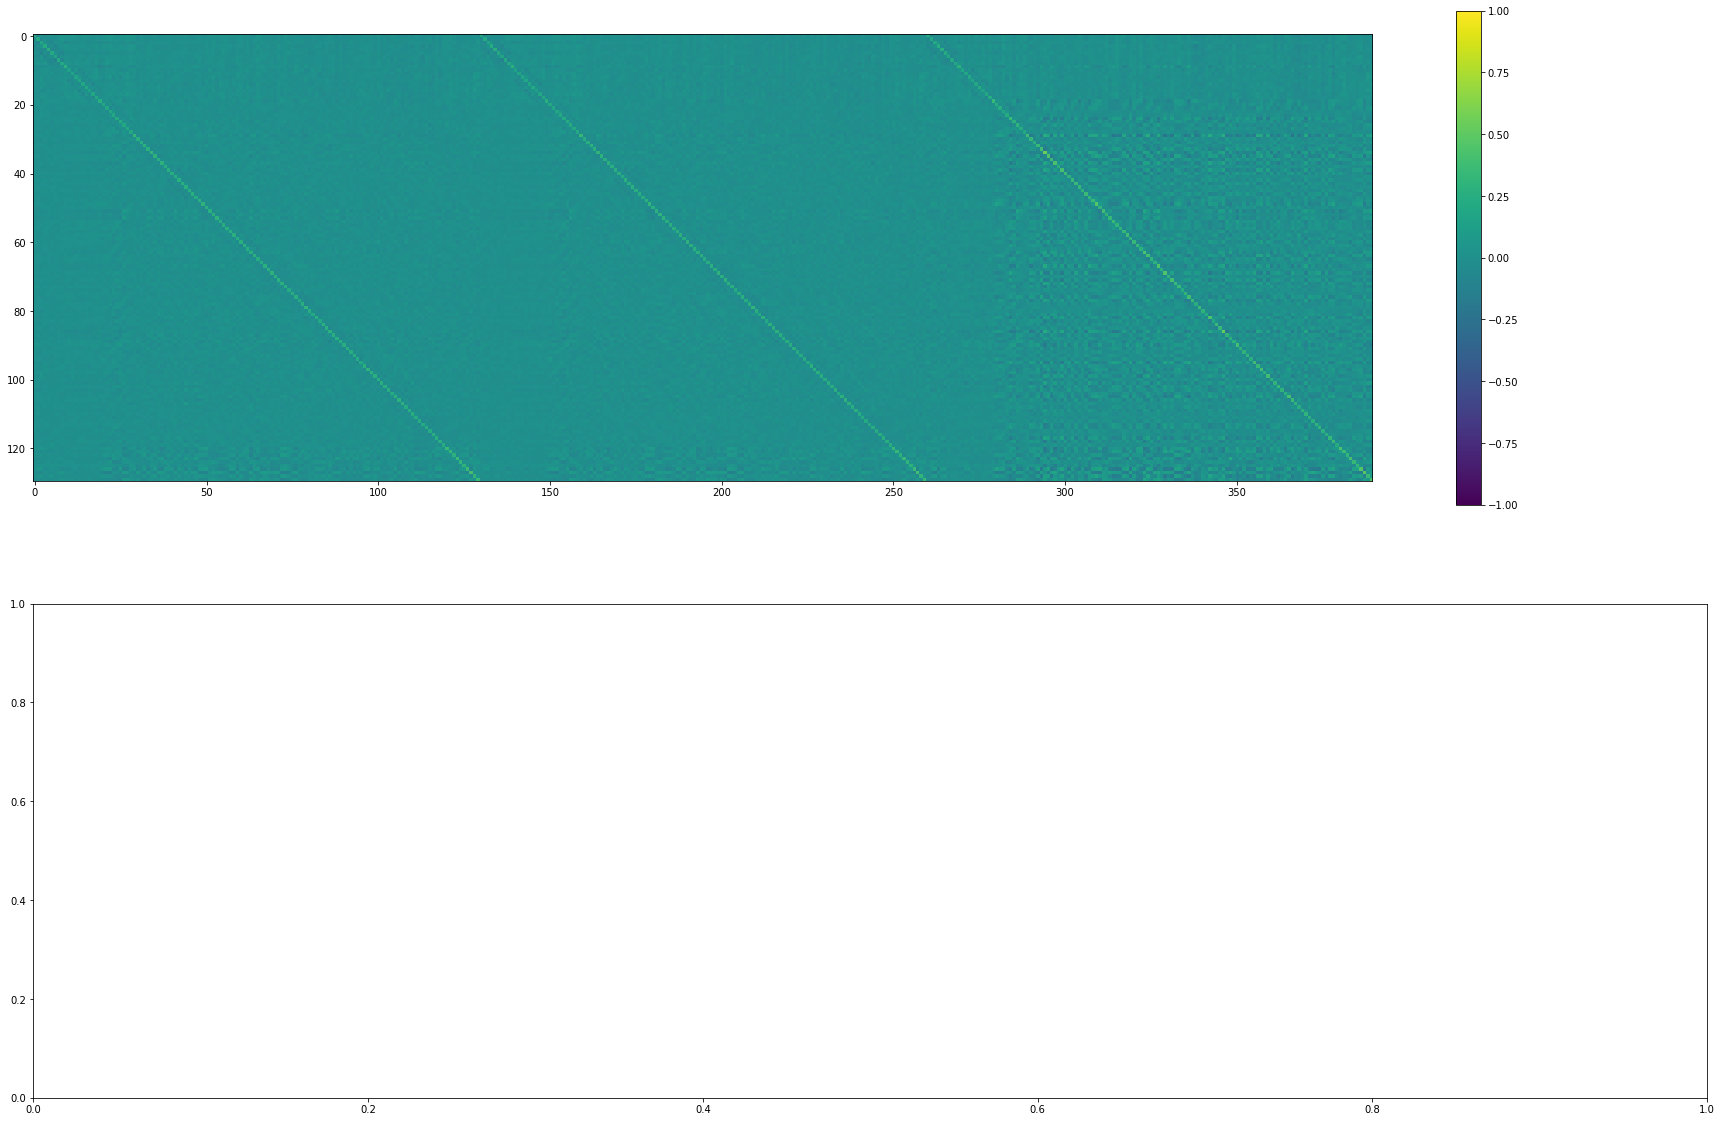

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.8978202939033508


  0%|          | 0/10 [00:00<?, ?it/s]

0.7755852937698364
0.7749916911125183
0.7753427028656006
0.7718893885612488
0.7648677229881287
0.7605075836181641
0.7593474388122559
0.747319757938385
0.7464326024055481
0.7447965741157532
input weight distribution
l2    :  5.0535888671875
cossim:  0.05508086830377579
output weight distribution
l2    :  12.38778018951416
cossim:  0.027853429317474365


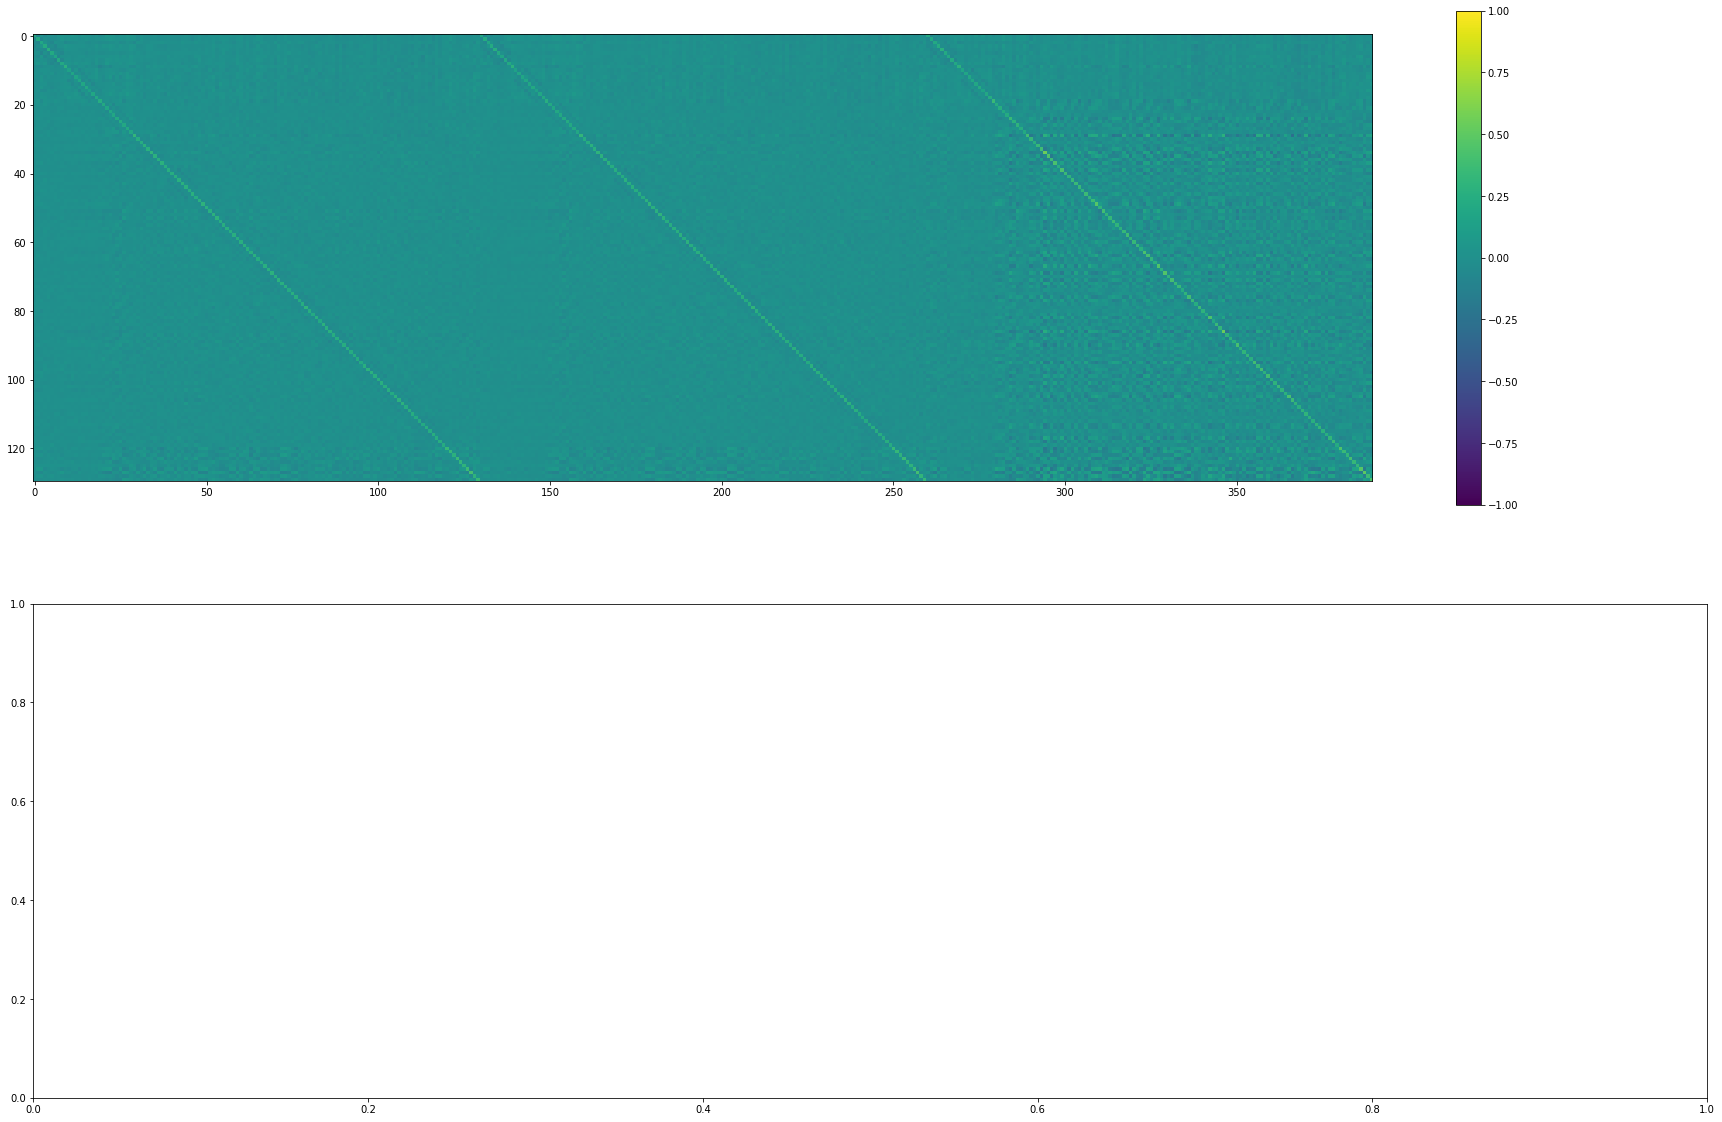

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.888149082660675


  0%|          | 0/10 [00:00<?, ?it/s]

0.7541511654853821
0.741435170173645
0.7361097931861877
0.7355215549468994
0.7306920289993286
0.735654890537262
0.7310190796852112
0.7256181240081787
0.7233604788780212
0.7286815643310547
input weight distribution
l2    :  5.0495829582214355
cossim:  0.05513667315244675
output weight distribution
l2    :  12.640729904174805
cossim:  0.023240335285663605


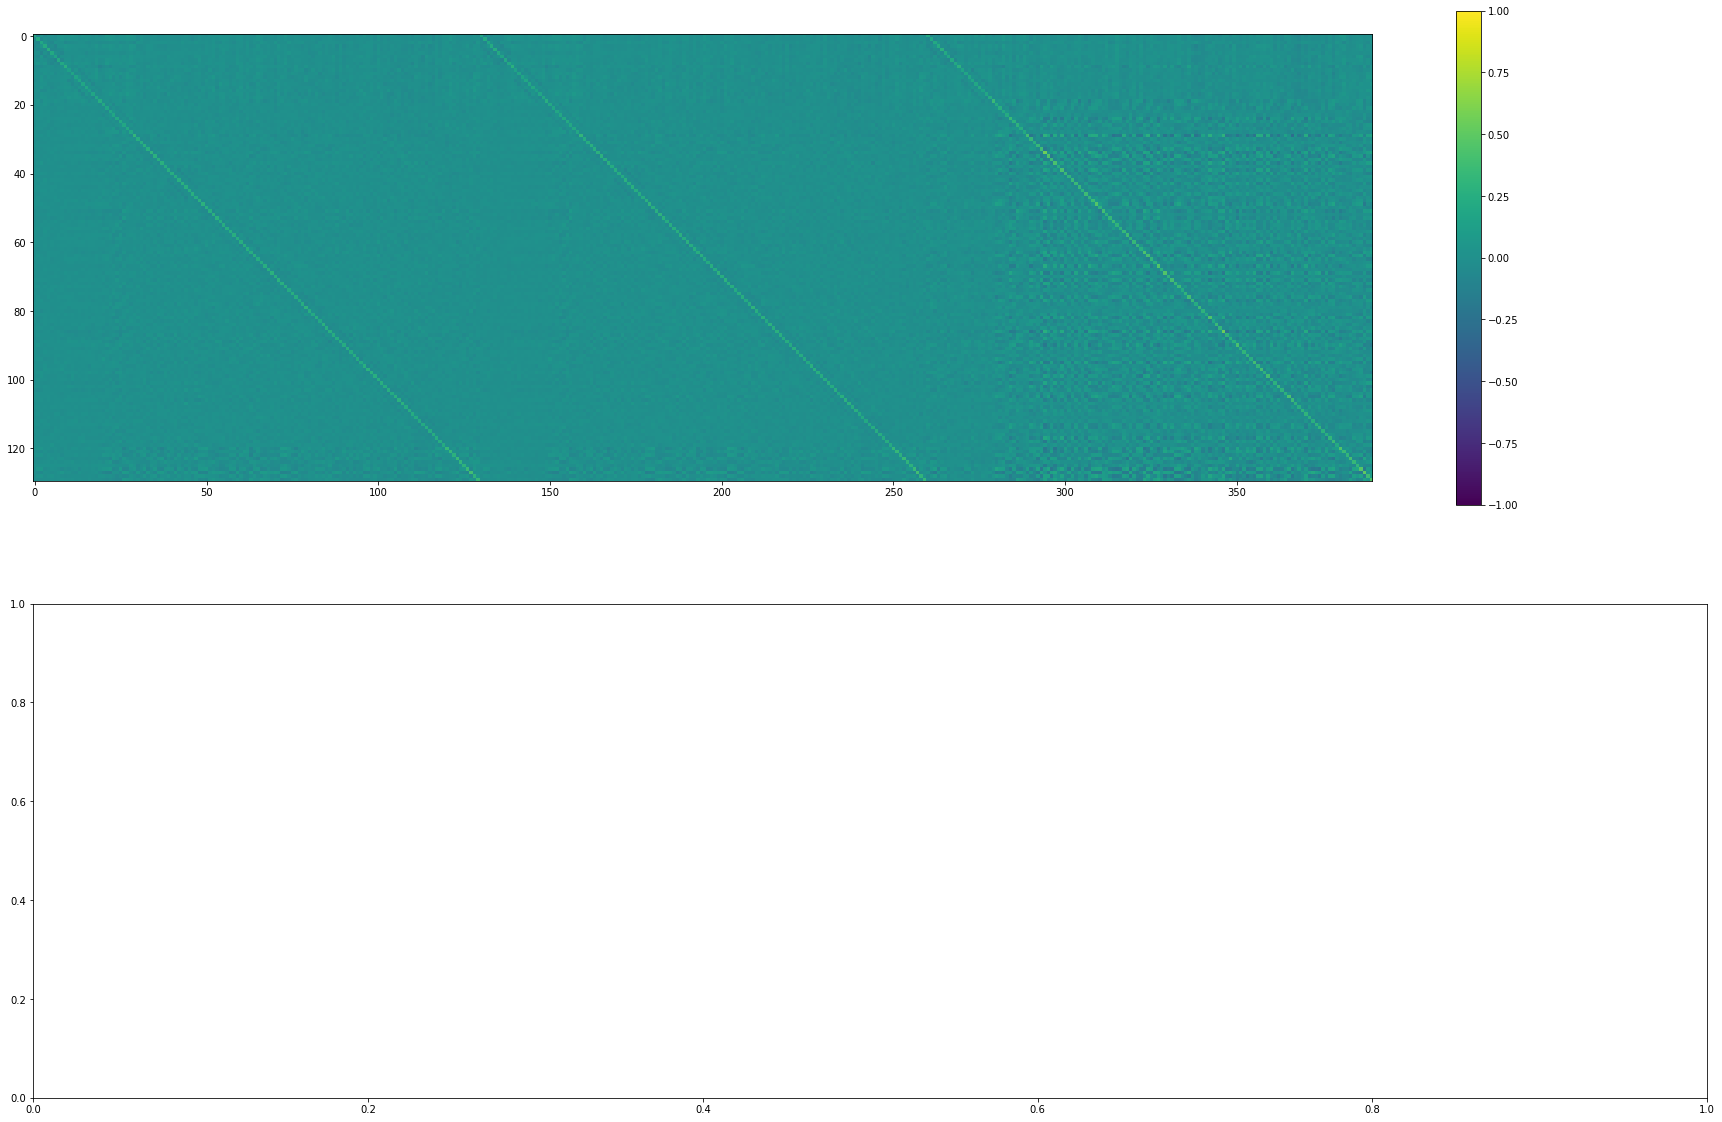

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.895484447479248


  0%|          | 0/10 [00:00<?, ?it/s]

0.715623140335083
0.7186251282691956
0.715064287185669
0.7092905044555664
0.7061893343925476
0.7098432779312134
0.7069377303123474
0.7057352066040039
0.7057069540023804
0.695366382598877
input weight distribution
l2    :  5.0682477951049805
cossim:  0.052441325038671494
output weight distribution
l2    :  12.674485206604004
cossim:  0.03279007971286774


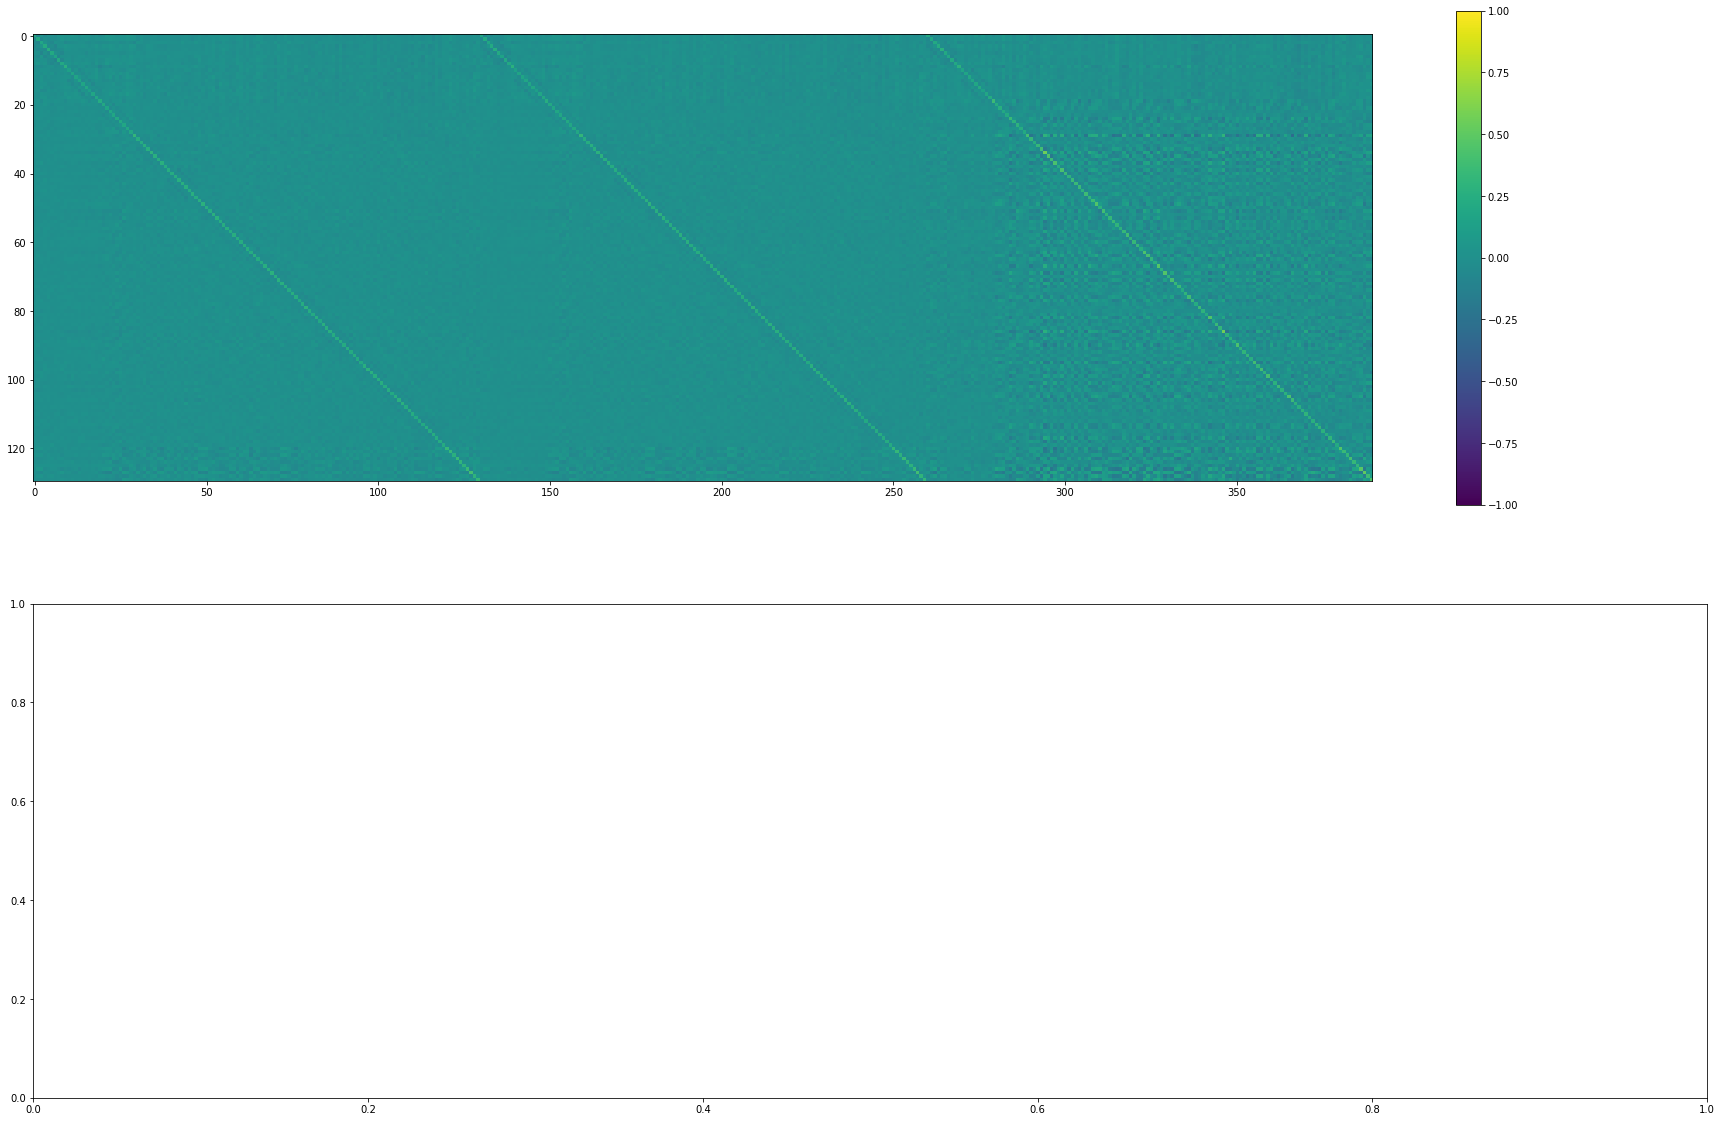

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.7926452159881592


  0%|          | 0/10 [00:00<?, ?it/s]

0.6962641477584839
0.6964318752288818
0.6945267915725708
0.6935630440711975
0.6908394694328308
0.6911482810974121
0.6887356042861938
0.6840628385543823
0.6852153539657593
0.6809511780738831
input weight distribution
l2    :  5.078314304351807
cossim:  0.05502789840102196
output weight distribution
l2    :  13.14770221710205
cossim:  0.021498406305909157


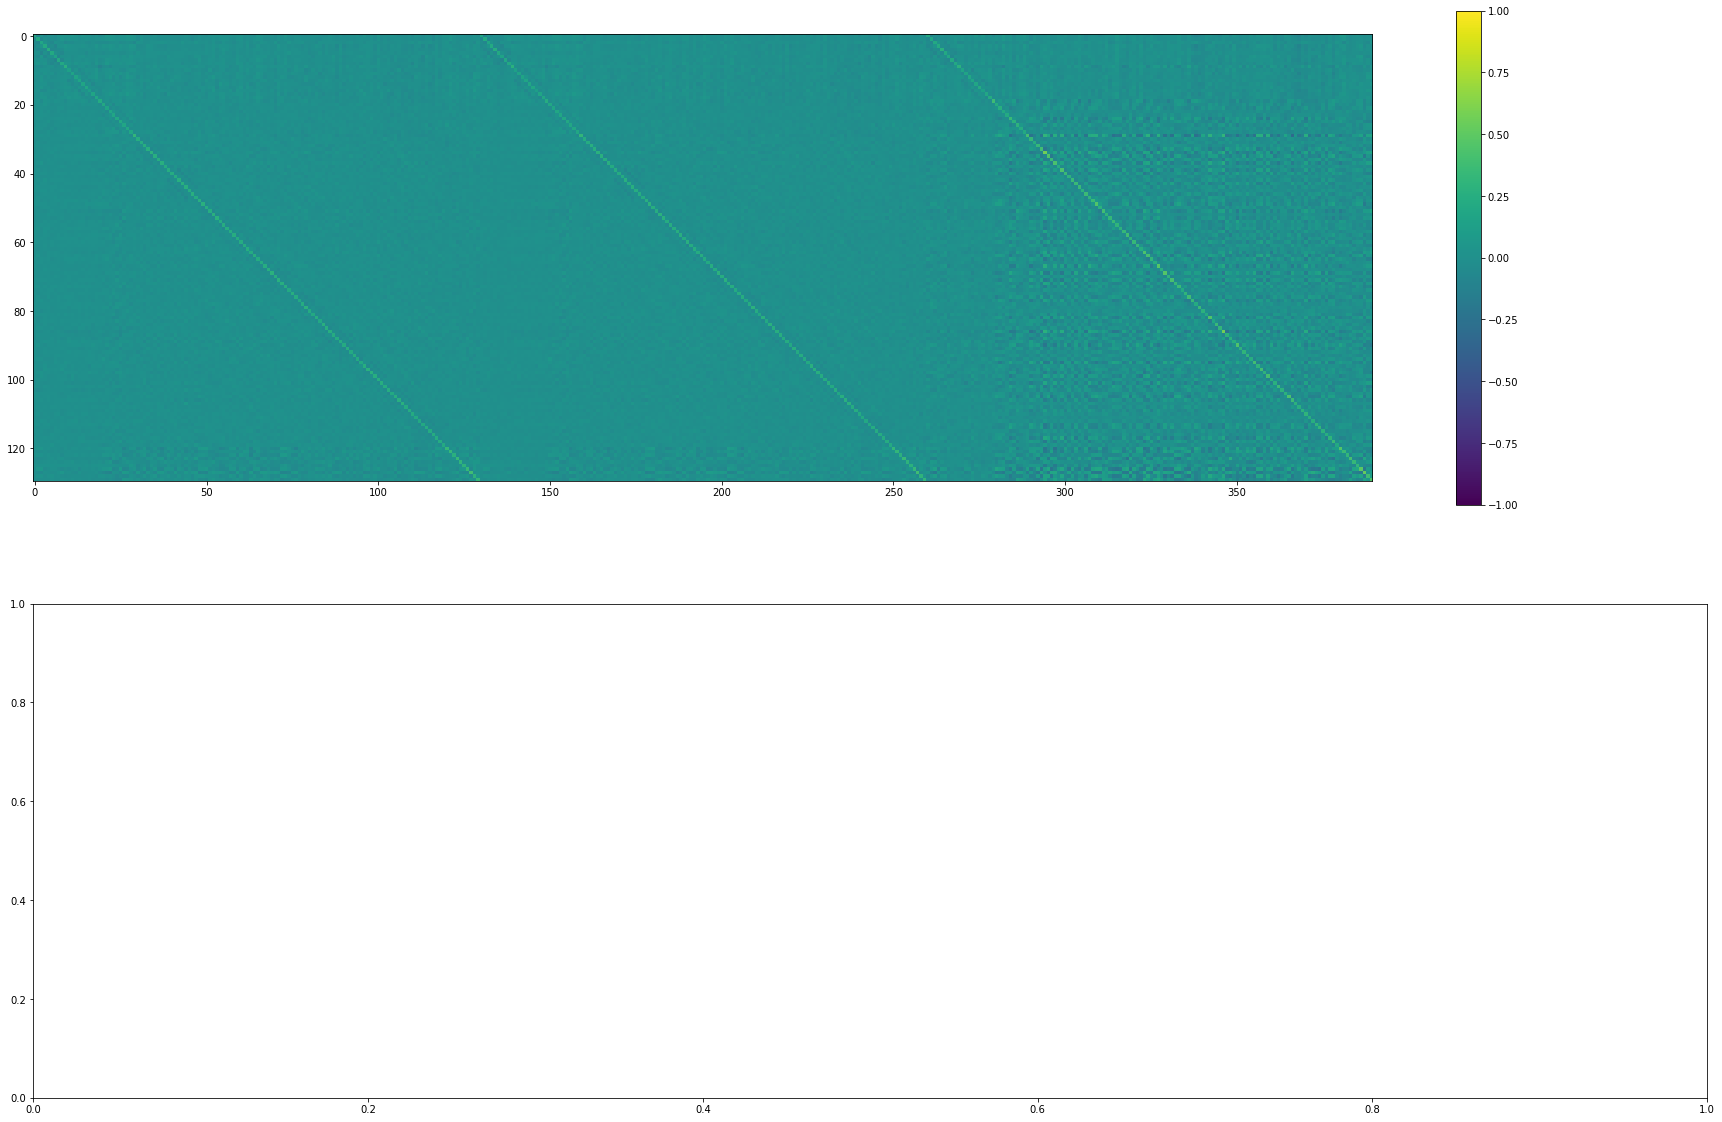

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.8050215244293213


  0%|          | 0/10 [00:00<?, ?it/s]

0.6787204146385193
0.6758403182029724
0.6774085164070129
0.678709089756012
0.6776138544082642
0.6698060631752014
0.6727936267852783
0.66961669921875
0.6693142652511597
0.6713985800743103
input weight distribution
l2    :  5.029098033905029
cossim:  0.06062725931406021
output weight distribution
l2    :  13.09908390045166
cossim:  0.024765735492110252


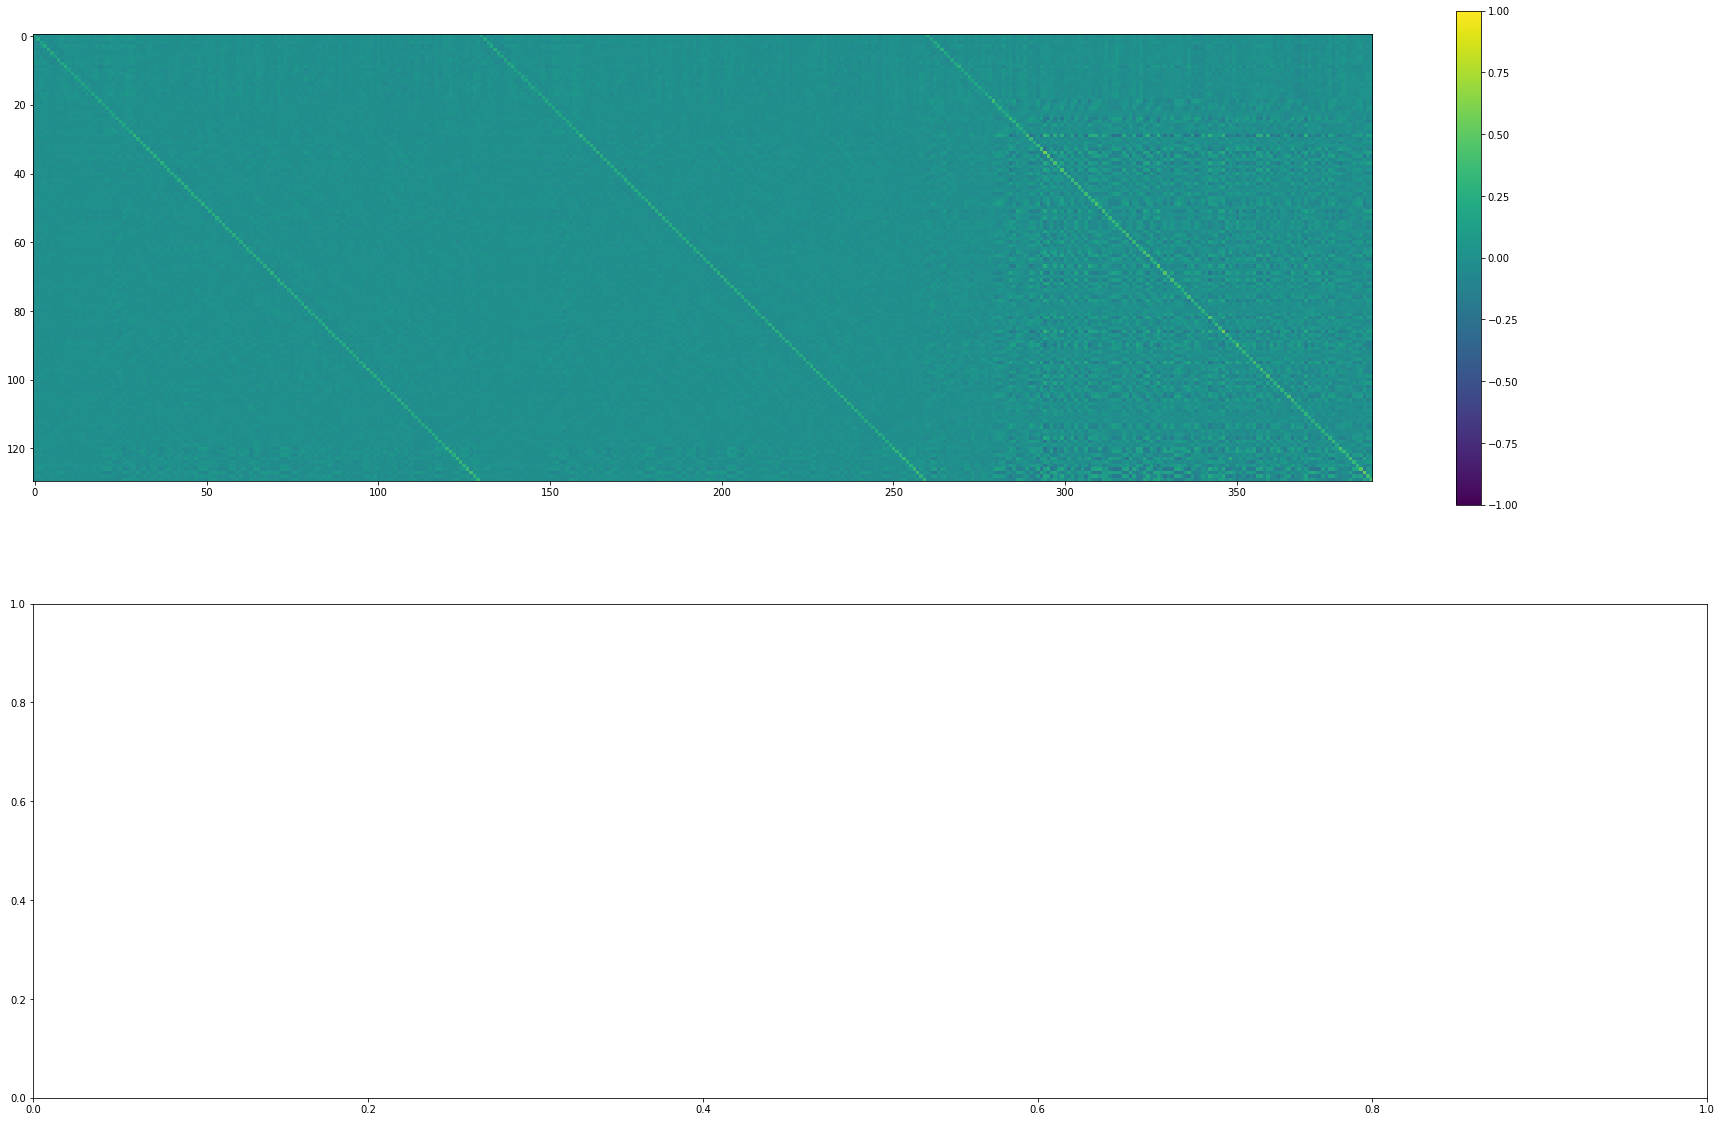

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.8108659386634827


  0%|          | 0/10 [00:00<?, ?it/s]

0.6696200966835022
0.6623295545578003
0.6674819588661194
0.662651777267456
0.6659766435623169
0.6611472368240356
0.6625195145606995
0.6630008816719055
0.6640476584434509
0.6594778299331665
input weight distribution
l2    :  5.075886249542236
cossim:  0.05463942885398865
output weight distribution
l2    :  13.472716331481934
cossim:  0.02201729454100132


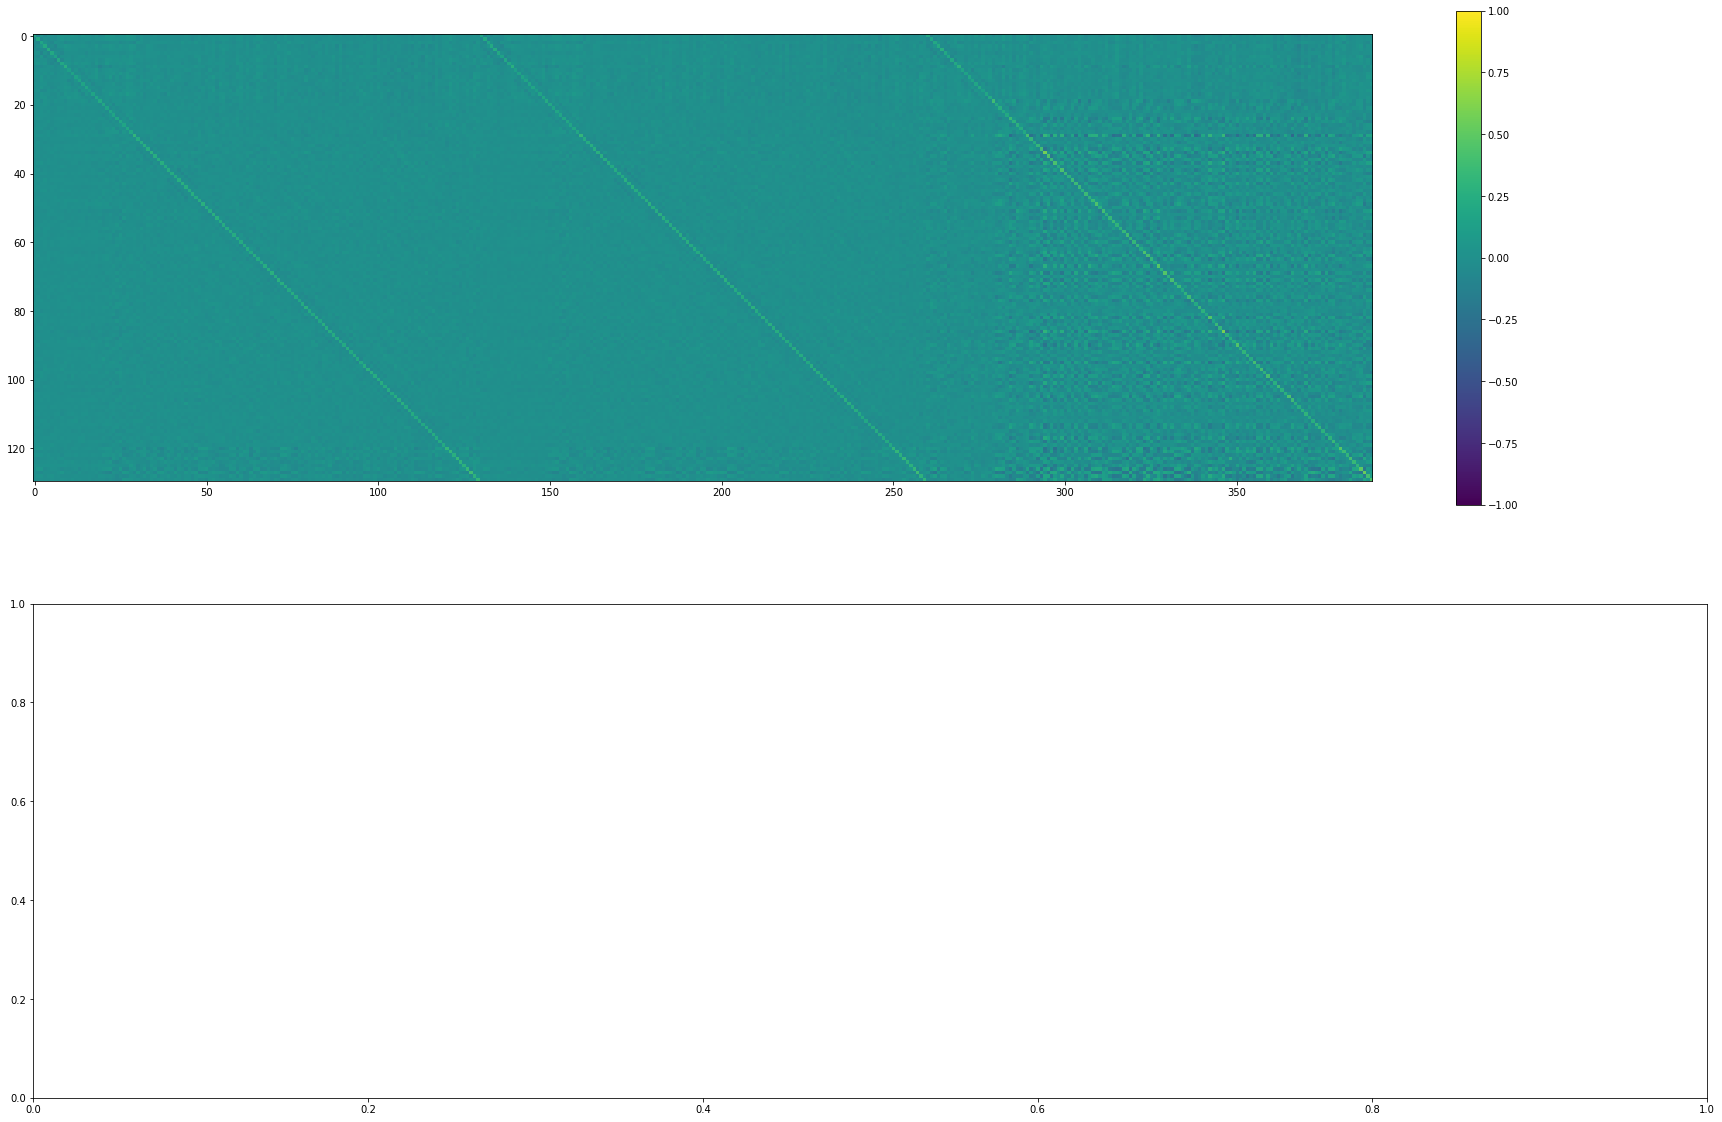

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.7822559475898743


  0%|          | 0/10 [00:00<?, ?it/s]

0.6569861173629761
0.6544913053512573
0.6513605713844299
0.6515767574310303
0.6577392816543579
0.6525110602378845
0.6541110873222351
0.6487496495246887
0.6523504853248596
0.6484848260879517
input weight distribution
l2    :  5.077705383300781
cossim:  0.05332436040043831
output weight distribution
l2    :  13.693342208862305
cossim:  0.020149126648902893


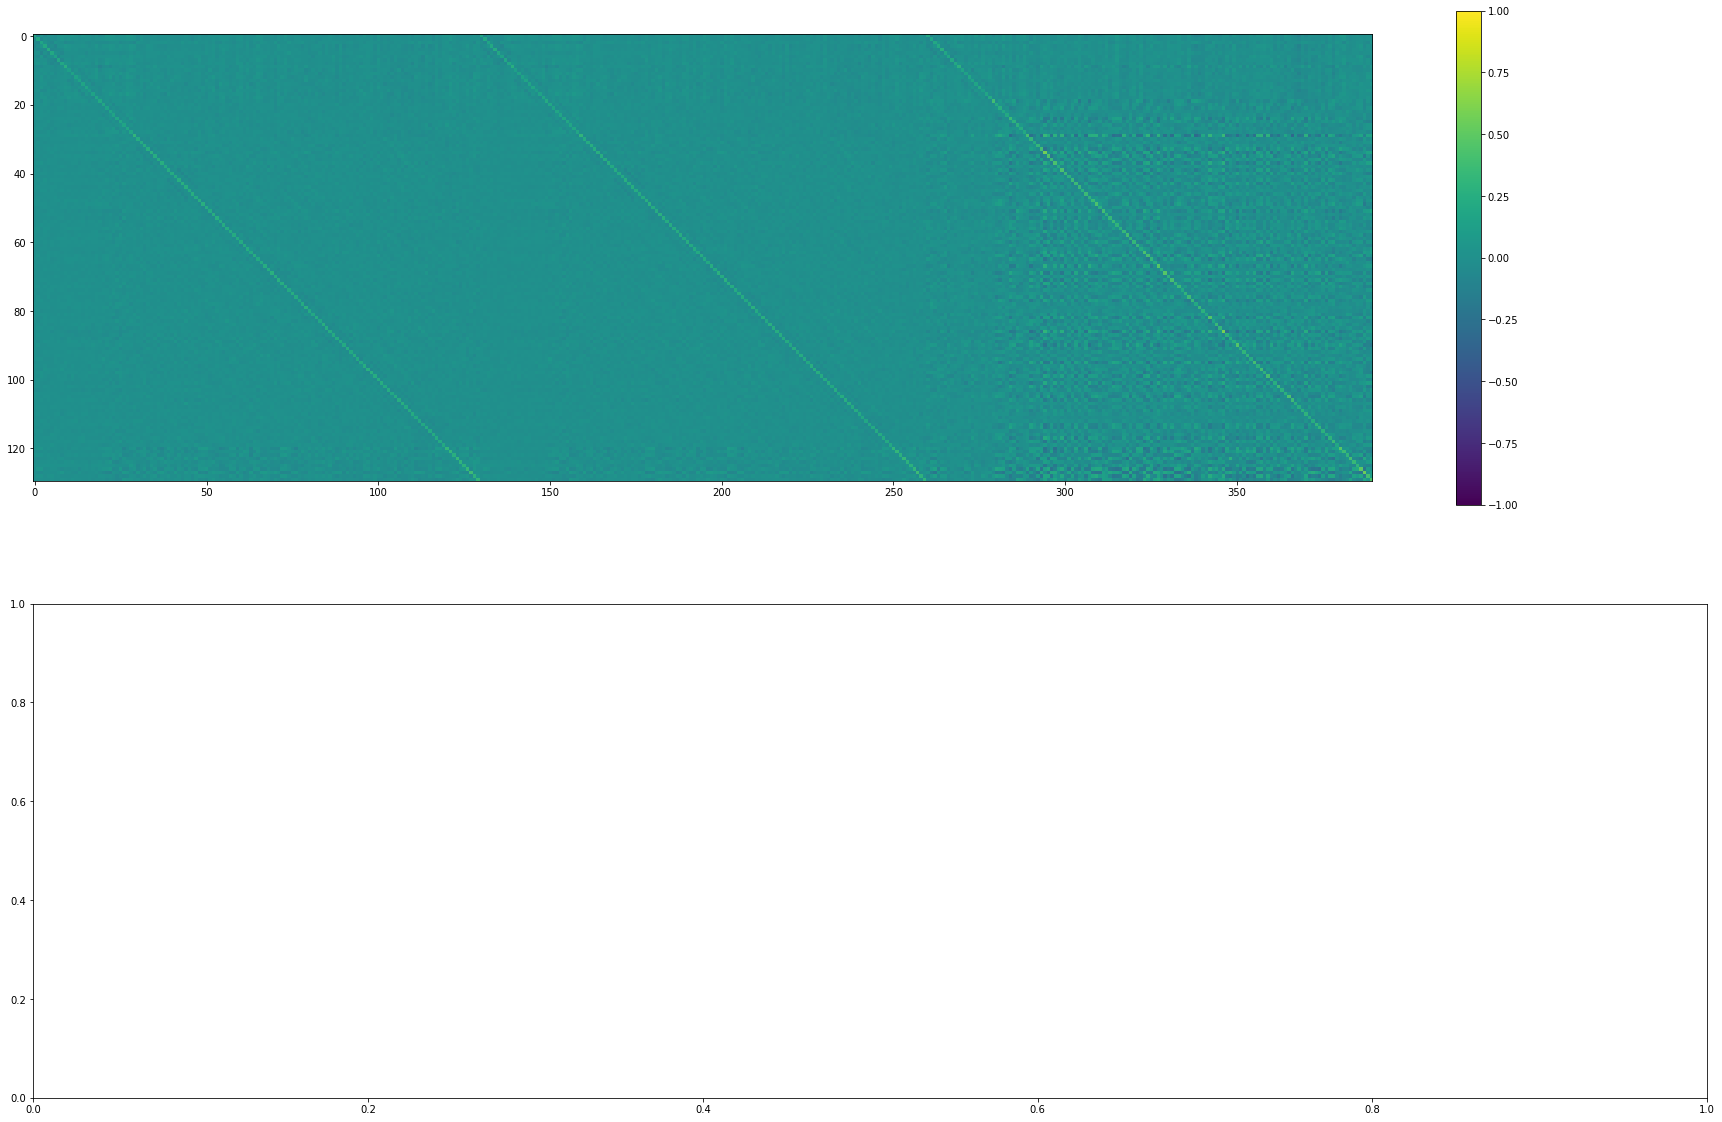

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.8290884494781494


  0%|          | 0/10 [00:00<?, ?it/s]

0.6552283763885498
0.6476079821586609
0.6460610032081604
0.6495789885520935
0.6448524594306946
0.647747814655304
0.640328049659729
0.6431061625480652
0.6472020745277405
0.6379023790359497
input weight distribution
l2    :  5.1152873039245605
cossim:  0.0526139922440052
output weight distribution
l2    :  13.687162399291992
cossim:  0.02629055082798004


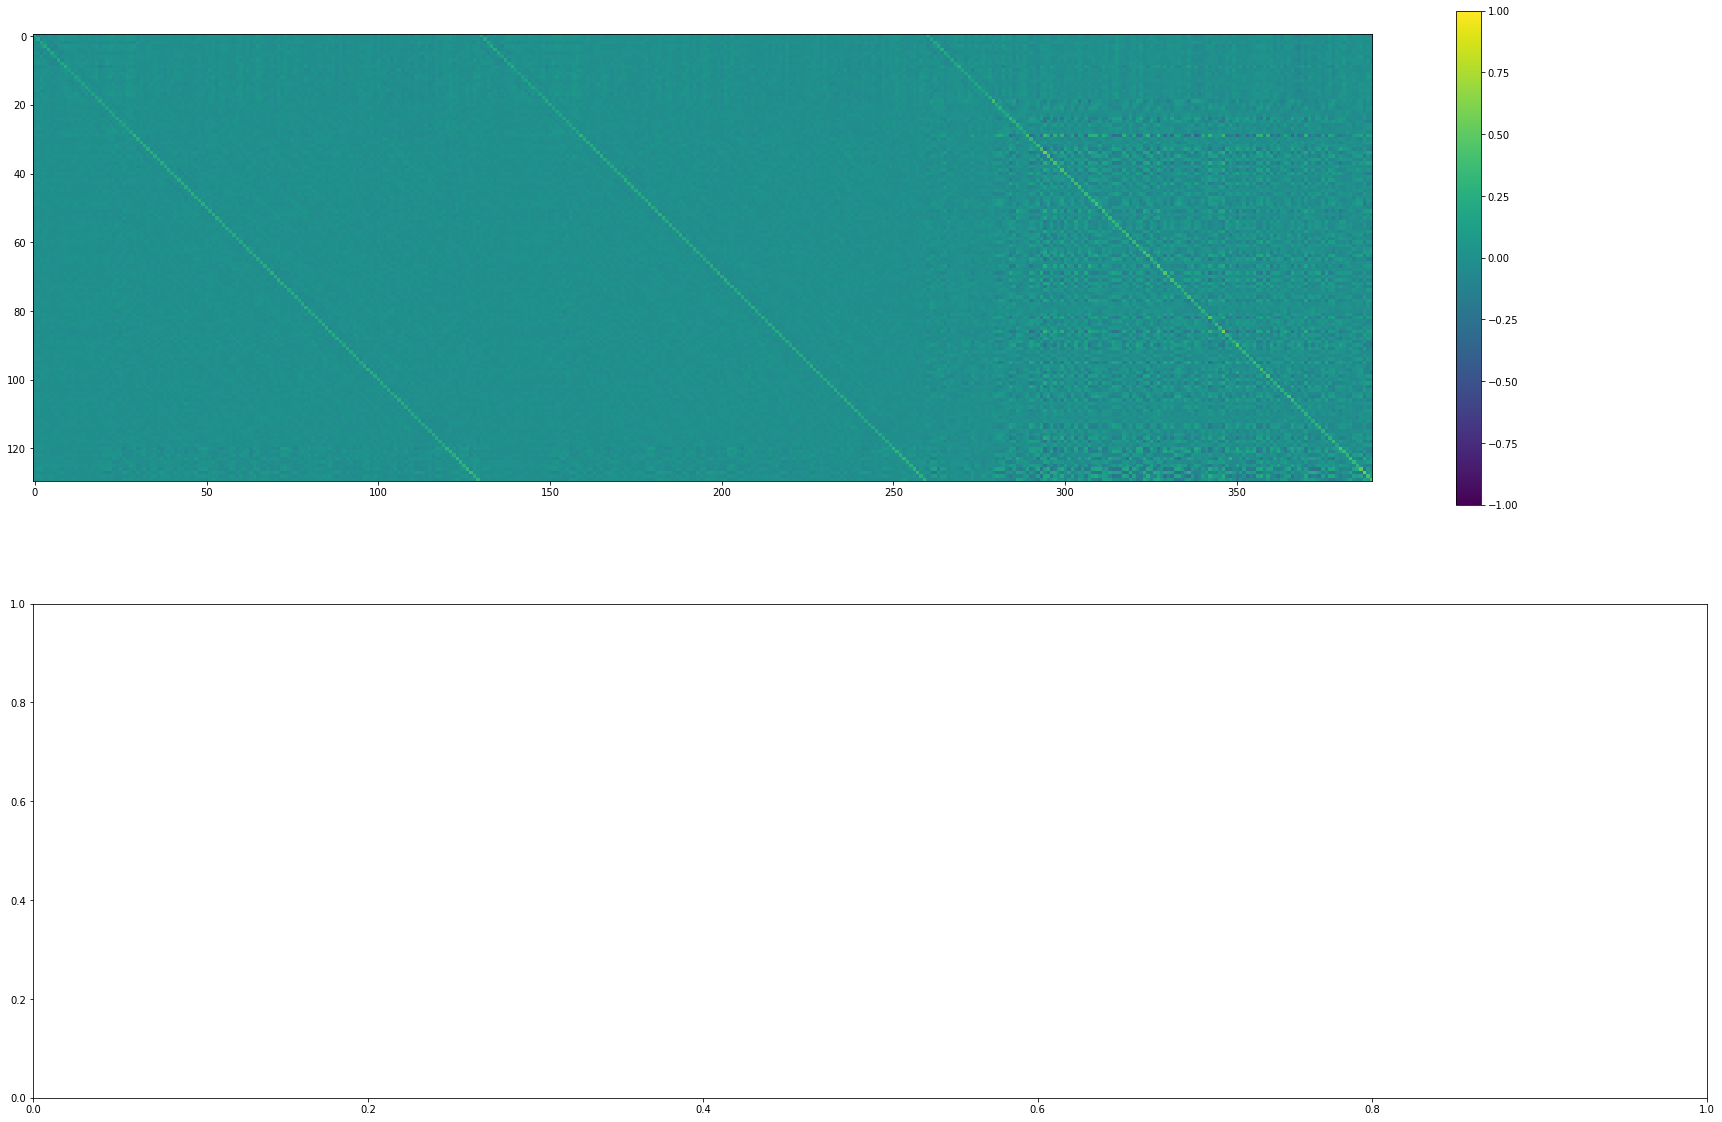

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.7675741314888


  0%|          | 0/10 [00:00<?, ?it/s]

0.6374077200889587
0.639315664768219
0.6370626091957092
0.6382204294204712
0.6411651372909546
0.6330657005310059
0.6379278898239136
0.636058509349823
0.6362984776496887
0.6329598426818848
input weight distribution
l2    :  5.073184967041016
cossim:  0.05537036806344986
output weight distribution
l2    :  14.203837394714355
cossim:  0.018176820129156113


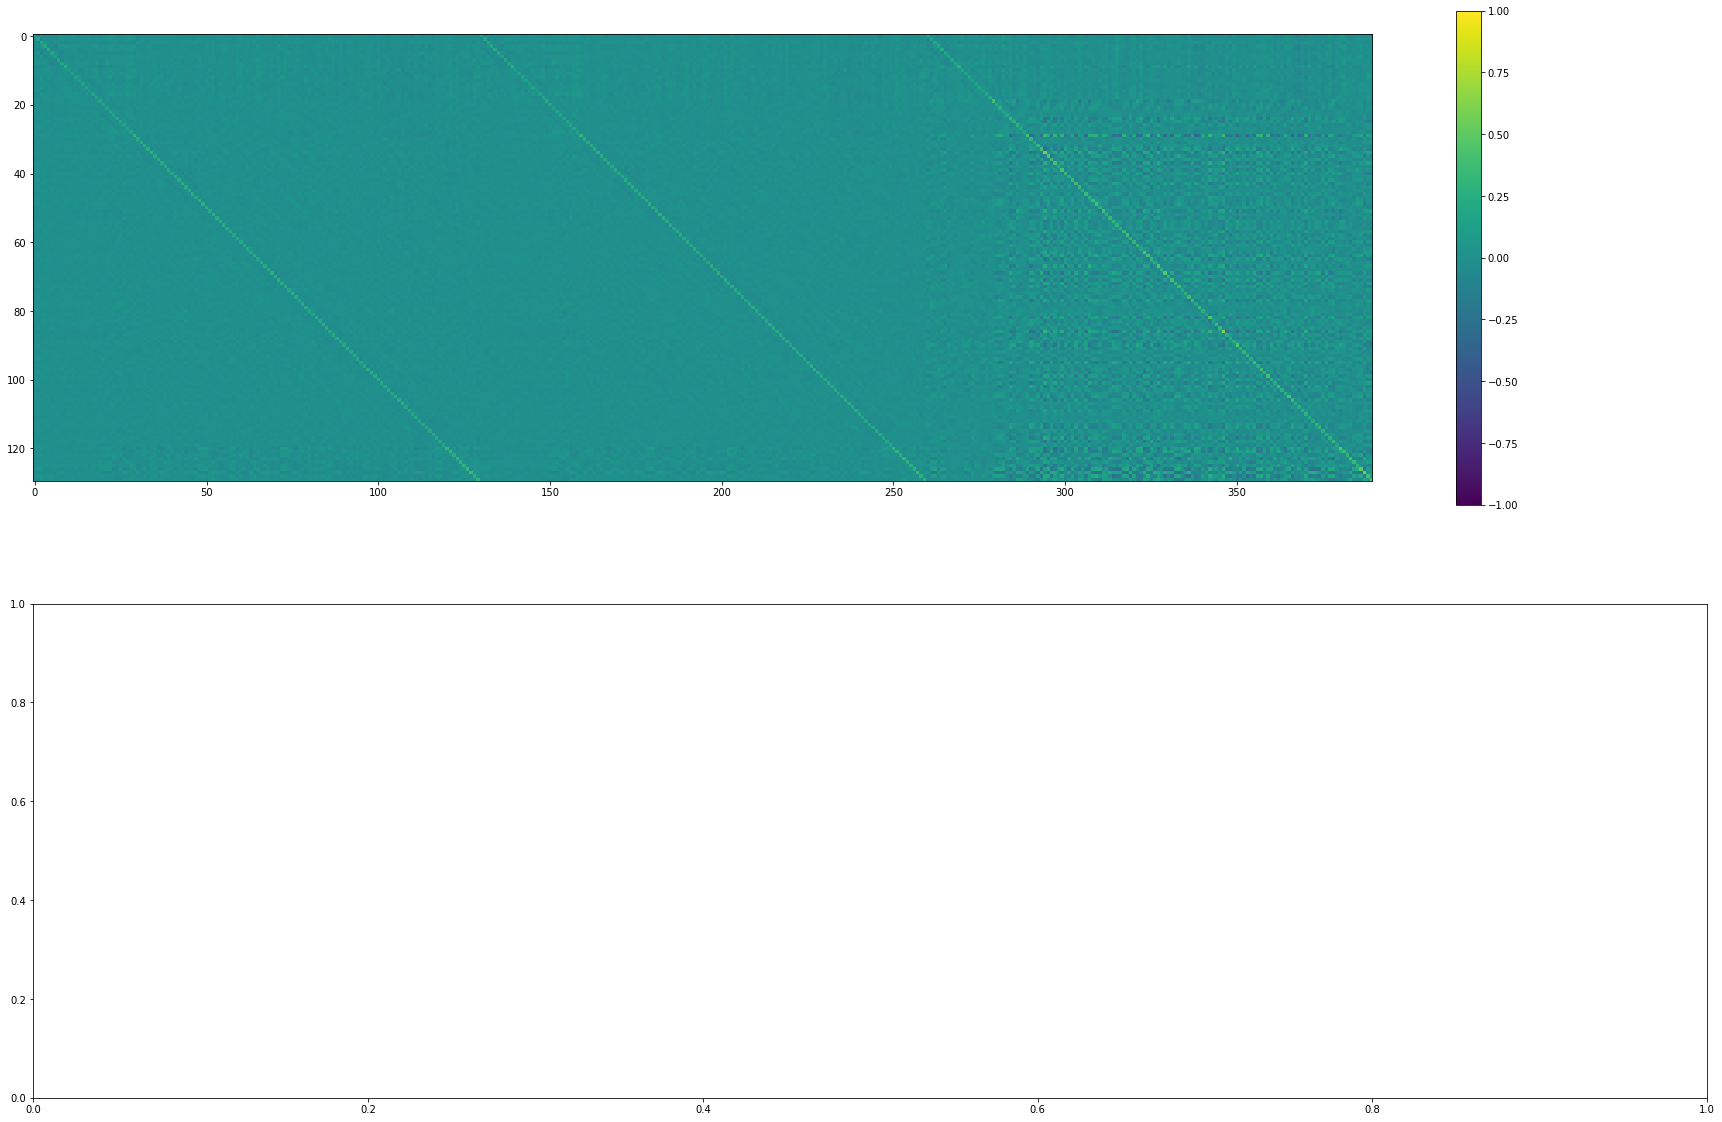

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.7994523644447327


  0%|          | 0/10 [00:00<?, ?it/s]

0.634194552898407
0.6354857683181763
0.6318305134773254
0.6309965252876282
0.6282087564468384
0.6275929808616638
0.6309767961502075
0.6260663866996765
0.6242180466651917
0.6242236495018005
input weight distribution
l2    :  5.06410551071167
cossim:  0.054786983877420425
output weight distribution
l2    :  14.416983604431152
cossim:  0.01798861287534237


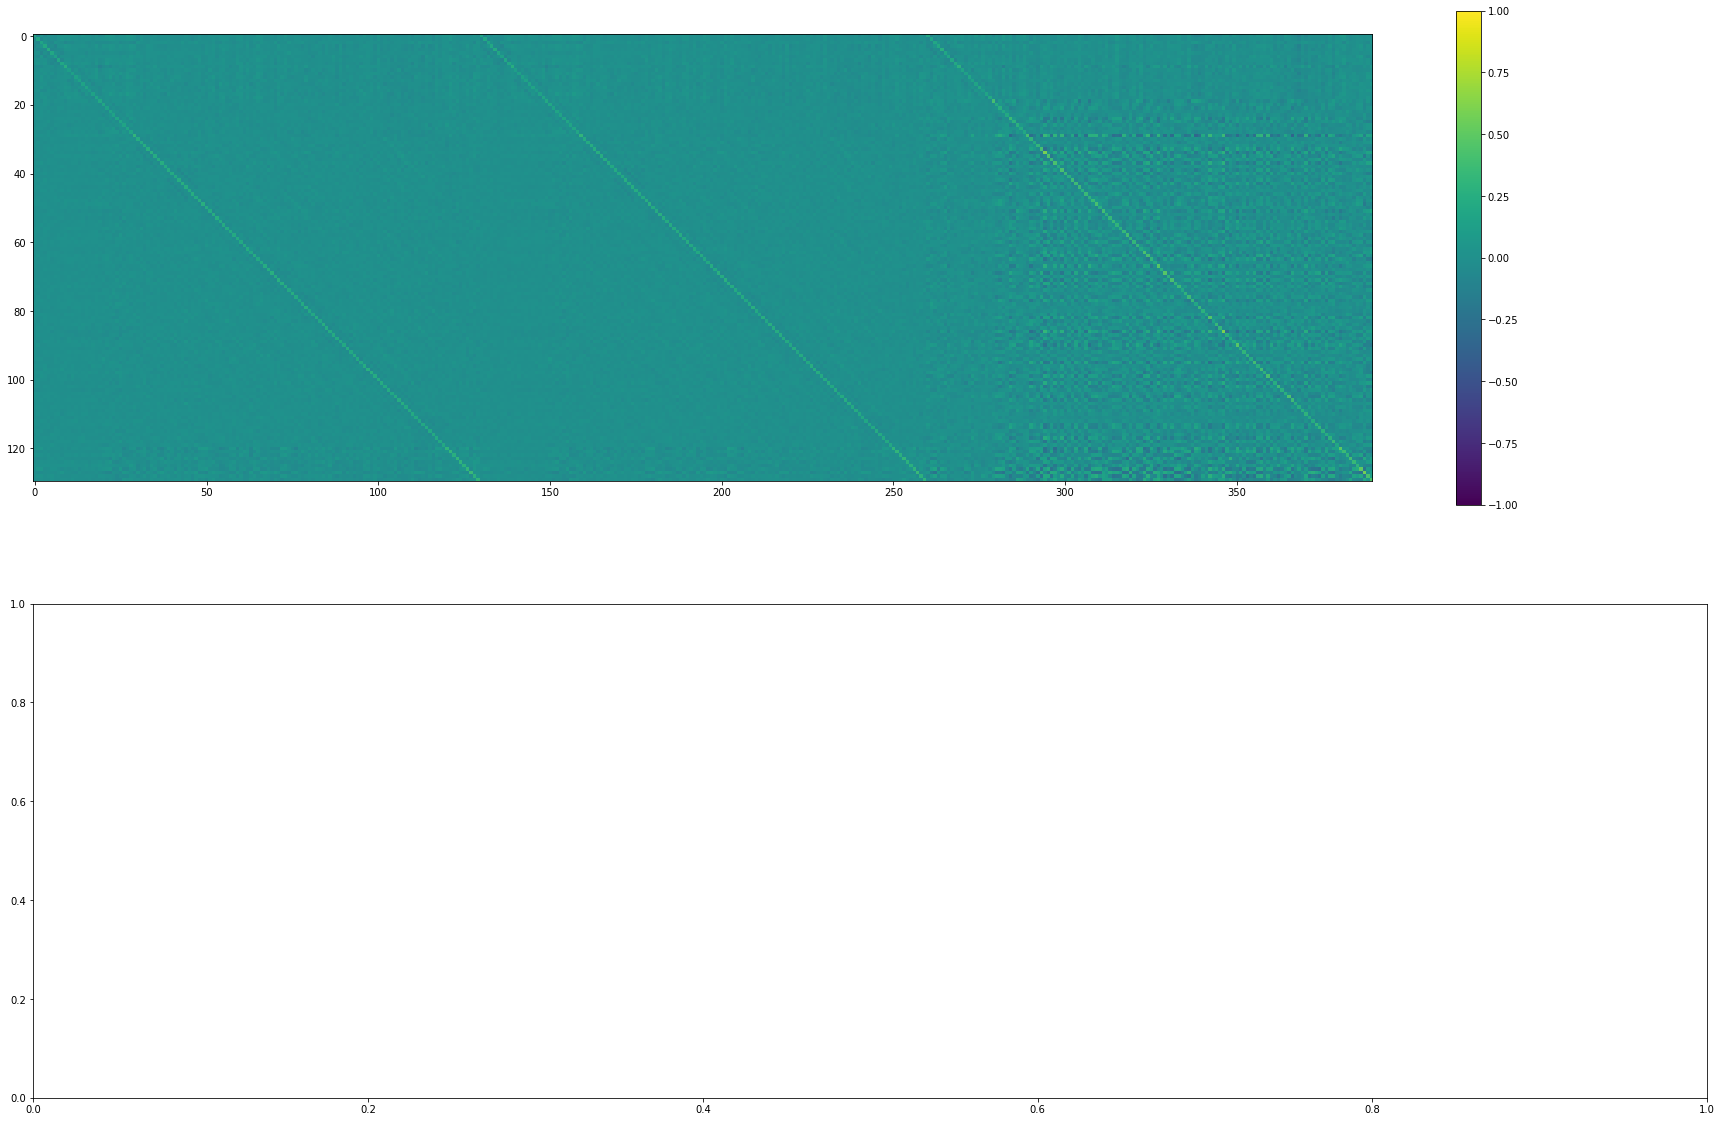

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.8312252759933472


  0%|          | 0/10 [00:00<?, ?it/s]

0.6263190507888794
0.628865659236908
0.6211325526237488
0.6248610019683838
0.6214094758033752
0.623733639717102
0.6211696863174438
0.6229677200317383
0.6188634037971497
0.6180960536003113
input weight distribution
l2    :  5.070937156677246
cossim:  0.05442950874567032
output weight distribution
l2    :  14.536392211914062
cossim:  0.017348874360322952


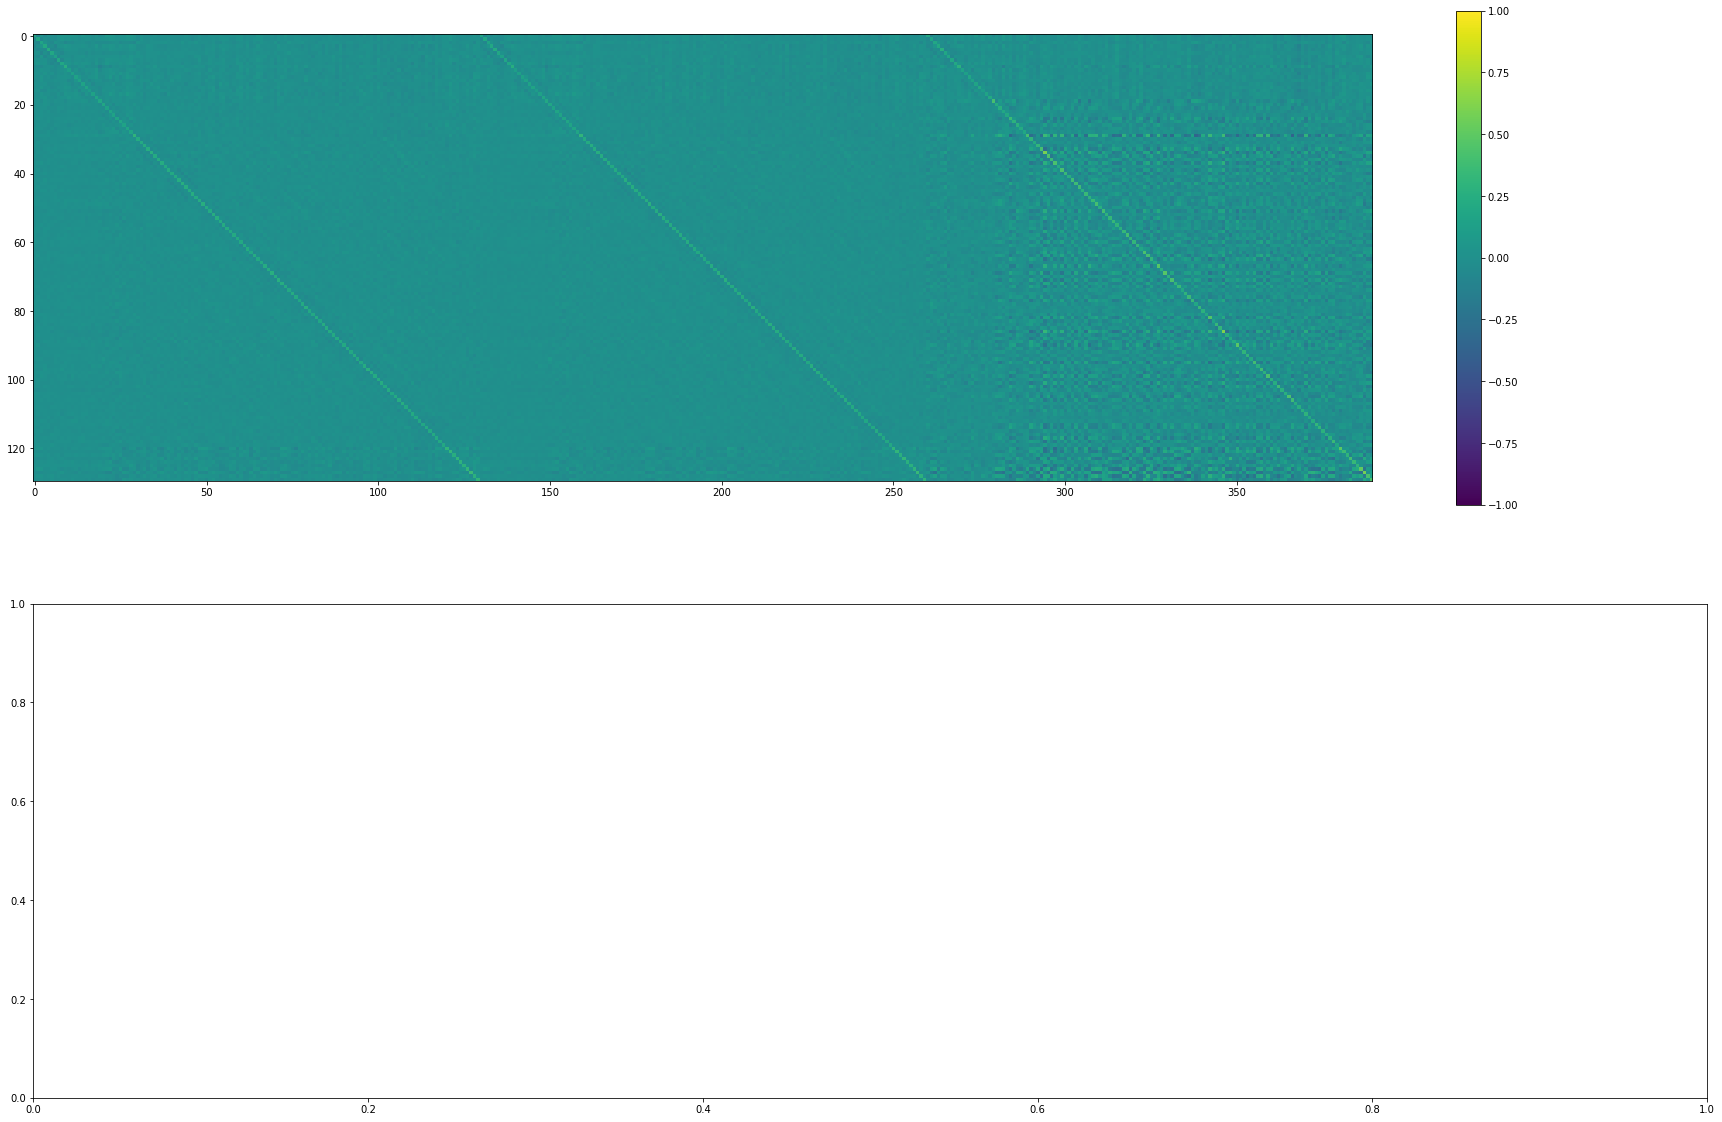

  0%|          | 0/1 [00:00<?, ?it/s]

Testing loss:  0.7752649188041687


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
net = net.to(device)
# conet = CONetConvexComb(0.6)
conet = CONetLinear(init_first=True)
conet = conet.to(device)
# opt = torch.optim.Adam(conet.parameters(), lr=1e-2)
opt = torch.optim.Adam(conet.parameters(), lr=2e-3)

for epoch_idx in tqdm(range(100)):
    for batch_idx, (input_weights, input_losses) in tqdm(enumerate(dl_net_test), total=len(dl_net_test), leave=False):
        input_weights, input_losses = input_weights.to(device), input_losses.to(device)
        output_weights = conet(input_weights)
        x, y = next(iter(dl_train))
        x, y = x.to(device), y.to(device)
        loss, grad, grad_div = batch_calc_loss_grad_vec(output_weights, net, x, y)
        print('Testing loss: ', loss.mean().item())
        
    for batch_idx, (input_weights, input_losses) in tqdm(enumerate(dl_net), total=len(dl_net), leave=False):
        input_weights, input_losses = input_weights.to(device), input_losses.to(device)
        output_weights = conet(input_weights)
        
        x, y = next(iter(dl_train))
        x, y = x.to(device), y.to(device)
        
        loss, grad, grad_div = batch_calc_loss_grad_vec(output_weights, net, x, y)
        
        opt.zero_grad()
        output_weights.backward(1e-3*grad+grad_div)
        opt.step()
#         print('grad: ', conet.t.grad)
        
#         print('t=', conet.t.item(), ': ', loss.mean().item())
        print(loss.mean().item())
    
    a = input_weights[:, 0, :]
    print('input weight distribution')
    print('l2    : ', (a[None]-a[:, None]).norm(dim=-1).mean().item())
    print('cossim: ', torch.cosine_similarity(a[None], a[:, None], dim=-1).mean().item())
    print('output weight distribution')
    a = output_weights
    print('l2    : ', (a[None]-a[:, None]).norm(dim=-1).mean().item())
    print('cossim: ', torch.cosine_similarity(a[None], a[:, None], dim=-1).mean().item())
    plt.figure(figsize=(30, 20))
    plt.subplot(211)
    plt.imshow(conet[1].weight.detach().cpu().numpy(), vmin=-1, vmax=1)
    plt.colorbar()
    plt.subplot(212)
#     plt.imshow(np.tile(conet[1].bias.detach().cpu().numpy(), [10, 1]), vmin=-1, vmax=1)
#     plt.colorbar()
    plt.show()

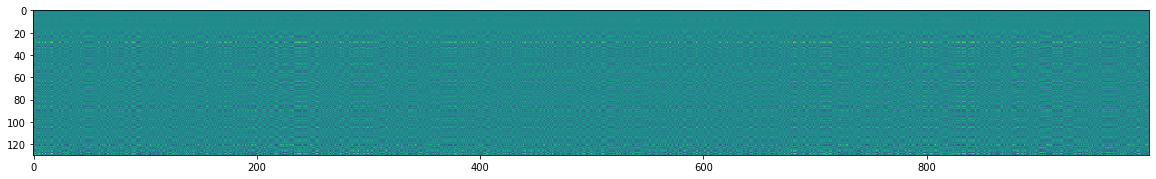

In [42]:
plt.figure(figsize=(20, 10))
plt.imshow(output_weights.detach().cpu().numpy().T)

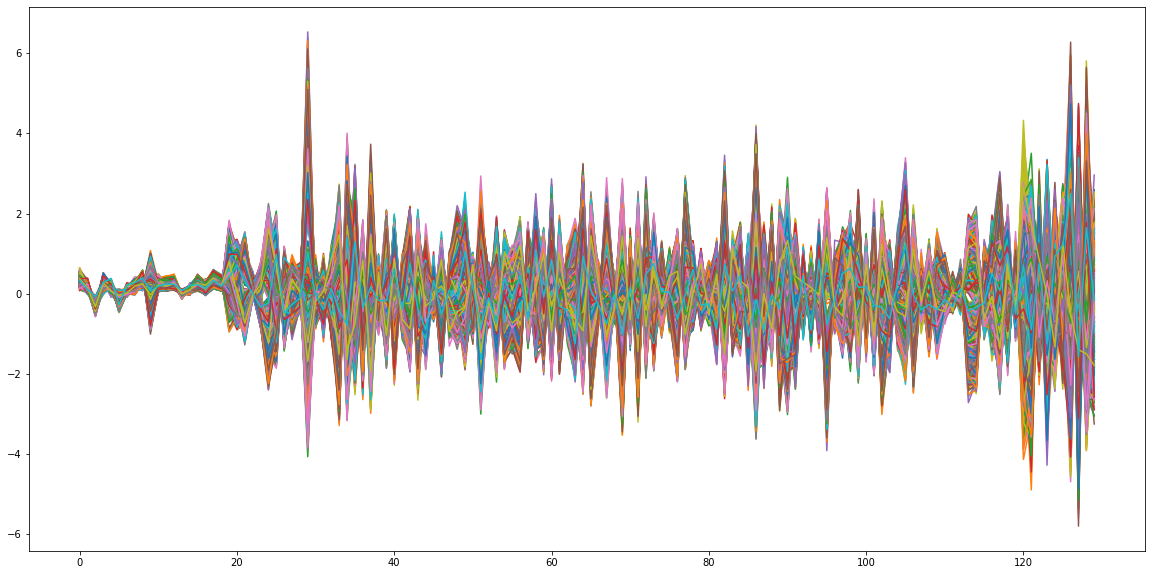

In [58]:
plt.figure(figsize=(20, 10))
plt.plot(output_weights.detach().cpu().numpy().T);
# plt.plot(output_weights.detach().cpu().numpy()[1])
# plt.plot(output_weights.detach().cpu().numpy()[2])
# plt.plot(output_weights.detach().cpu().numpy()[3])
# plt.plot(output_weights.detach().cpu().numpy()[4])

In [70]:
input_weights[0,0],output_weights[0]

(tensor([ 7.4693e-01,  1.2165e-01,  2.0820e-01,  3.5916e-01,  4.7012e-01,
          4.0357e-01,  1.0776e-02,  5.4865e-01,  4.5129e-01,  3.0006e-01,
         -1.1181e-01, -3.5508e-01, -2.5973e-01,  2.7665e-01, -3.6615e-01,
          2.3189e-01,  3.2683e-01,  3.3569e-01,  5.2556e-01,  2.4814e-01,
         -8.3754e-02,  4.5437e-03, -4.1117e-01,  4.1022e-01, -1.5042e-02,
          7.6836e-02,  8.1089e-02,  5.1904e-02,  5.8464e-01, -3.7106e-02,
         -5.7762e-01, -1.0243e-01, -7.3652e-01,  1.7609e-01,  2.8473e-01,
         -6.5335e-01,  3.7655e-01,  8.3813e-02, -4.4970e-04,  4.0037e-01,
         -2.9720e-01, -1.8123e-01, -1.5849e-01,  1.7044e-01, -2.7017e-01,
         -4.8093e-01,  3.1219e-01,  7.0657e-02, -4.1947e-01, -3.3794e-01,
         -2.5350e-01,  3.6769e-01,  1.4120e-01,  3.6566e-01, -2.0327e-01,
         -1.7254e-02, -4.1277e-02, -6.0622e-01, -2.5643e-01,  1.2556e-01,
         -3.0901e-01,  2.3889e-01,  3.2793e-01,  1.9183e-01,  1.3873e-01,
         -5.9129e-01,  4.7395e-01,  4.

In [72]:
torch.save(conet, 'conet.th')

In [29]:
conet = torch.load('conet.th')

In [172]:
next(iter(dl_net_test))[0].mean(axis=-1).flatten().shape

torch.Size([300])

In [173]:
next(iter(dl_net))[0].mean(axis=-1).flatten().shape

torch.Size([3000])

In [41]:
x, y = next(iter(dl_train))
x, y = x.to(device), y.to(device)

input_weights = next(iter(dl_net_test))[0].to(device)
# input_weights = torch.randn_like(input_weights)/4.
output_weights = conet(input_weights)

loss, grad, grad_div = batch_calc_loss_grad_vec(input_weights[:, 0, :], net, x, y)
print(loss.mean().item())
loss, grad, grad_div = batch_calc_loss_grad_vec(output_weights, net, x, y)
print(loss.mean().item())

1.5293023586273193
0.7836205959320068


In [133]:
input_weights = []
for i in tqdm(range(30)):
    net = models_pheno.SmallNet().to(device)
#     input_weights.append(util.model2vec(net).clone())
    a, _, _ = train_net(net, dl_train, n_epochs=1, device=device, tqdm=None)
    if a is not None:
        input_weights.append(util.model2vec(net).clone())
#     input_weights.append(torch.randn_like(input_weights[0])/4.)
input_weights = torch.stack(input_weights)

  0%|          | 0/30 [00:00<?, ?it/s]

2.30238676071167
FAIL
2.30216121673584
FAIL
0.8641133308410645
0.9737995862960815
2.3020248413085938
FAIL
1.0399041175842285
1.0586174726486206
2.302520513534546
FAIL
2.301753282546997
FAIL
1.2768208980560303
0.8474970459938049
2.3017351627349854
FAIL
2.3022007942199707
FAIL
1.4780112504959106
1.3438340425491333
1.2639224529266357
1.4366066455841064
2.3021504878997803
FAIL
1.2670212984085083
1.2244071960449219
1.0416382551193237
2.301973342895508
FAIL
1.0509116649627686
1.8959872722625732
0.9961934685707092
2.302586078643799
FAIL
2.302304744720459
FAIL
1.0428637266159058
1.052196979522705
0.9851279854774475


In [136]:
input_weights = input_weights[torch.randint(low=0, high=len(input_weights), size=(1500,))]

In [176]:
# input_weights = next(iter(dl_net_test))[0].to(device)
input_weights = iw
output_weights = conet(input_weights)

loss_in, grad, grad_div = batch_calc_loss_grad_vec(input_weights[:, 0, :], net, x, y)
print(loss_in.mean().item())
loss_out, grad, grad_div = batch_calc_loss_grad_vec(output_weights, net, x, y)
print(loss_out.mean().item())

EinopsError:  Error while computing Rearrange('b k w -> b (k w)')
 Expected 3 dimensions, got 2

In [143]:
loss_in = loss_in.reshape(500, 3)

In [144]:
loss_in.shape, loss_out.shape

(torch.Size([500, 3]), torch.Size([500]))

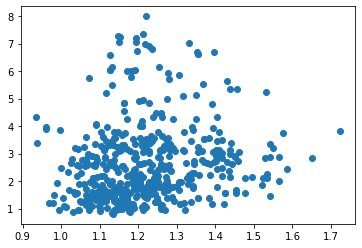

In [156]:
plt.scatter(loss_in.numpy().mean(axis=-1), loss_out.numpy())
# plt.errorbar(x=loss_in.numpy().mean(axis=-1), 
#              y=loss_out.numpy(),
#              xerr=loss_in.numpy().std(axis=-1), fmt='o')

In [ ]:
# 

In [180]:
x, y = next(iter(dl_train))
x, y = x.to(device), y.to(device)

input_weights = next(iter(dl_net))[0].to(device)
output_weights = conet(input_weights)

loss, grad = batch_calc_loss_grad_vec(input_weights[:, 0, :], net, x, y)
print(loss.mean().item())
loss, grad = batch_calc_loss_grad_vec(output_weights, net, x, y)
print(loss.mean().item())

1.3004553318023682
0.5270594358444214


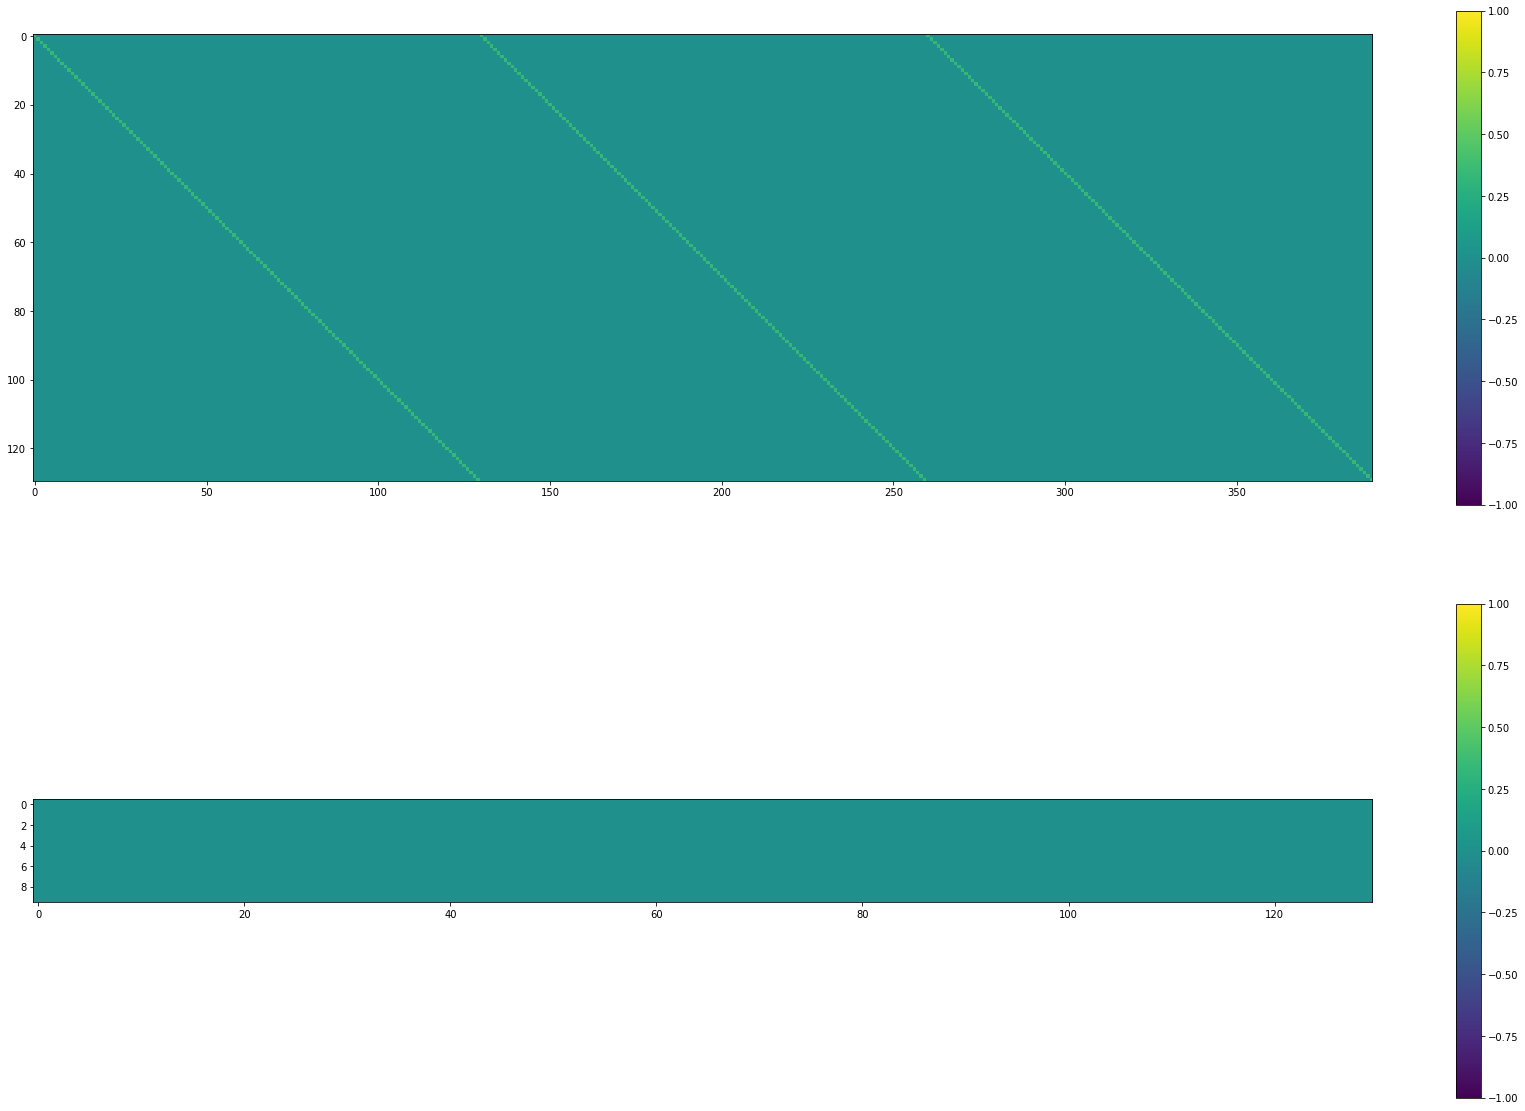

In [118]:
conet = CONetLinear(init_first=True)
plt.figure(figsize=(30, 20))
plt.subplot(211)
plt.imshow(conet[1].weight.detach().cpu().numpy(), vmin=-1, vmax=1)
plt.colorbar()
plt.subplot(212)
plt.imshow(np.tile(conet[1].bias.detach().cpu().numpy(), [10, 1]), vmin=-1, vmax=1)
plt.colorbar()
plt.show()


In [278]:
net = net.to(device)
weights = (torch.randn(130)/4).to(device).requires_grad_()
opt = torch.optim.Adam([weights], lr=1e-2)
opt2 = torch.optim.Adam(net.parameters(), lr=1e-2)

loop1 = range(1)
for epoch_idx in loop1:
    loop2 = enumerate(dl_train)
    for batch_idx, (X_batch, Y_batch) in loop2:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        net = util.vec2model(weights, net)
        Y_batch_pred = net(X_batch)

        loss = loss_fn(Y_batch_pred, Y_batch)
        
        opt.zero_grad()
        opt2.zero_grad()
        
        loss.backward()
        weights.backward(modelgrad2vec(net))
#         weights.grad = modelgrad2vec(net)
        
        opt.step()
        
        print(loss.item())

2.3129842281341553
2.3111631870269775
2.3031930923461914
2.310865879058838
2.3003385066986084
2.2995967864990234
2.2982120513916016
2.3040382862091064
2.28479266166687
2.285640239715576
2.278459310531616
2.2652580738067627
2.269397020339966
2.2694668769836426
2.2637555599212646
2.2544703483581543
2.250048875808716
2.23844051361084
2.221872329711914
2.23321270942688
2.20637845993042
2.213125467300415
2.201493978500366
2.2000131607055664
2.1698780059814453
2.164766550064087
2.156481981277466
2.149627923965454
2.1229500770568848
2.093980312347412
2.125466823577881
2.098940849304199
2.078906536102295
2.04414701461792
2.0532658100128174
2.0521843433380127
2.010922908782959
1.9878333806991577
1.9750975370407104
1.9774733781814575
1.917434573173523
1.9992127418518066
1.9874861240386963
1.8766132593154907
1.9555143117904663
1.9266071319580078
1.9194003343582153
1.8079317808151245
1.7628238201141357
1.908777117729187
1.7909170389175415
1.764322280883789
1.7615859508514404
1.6544173955917358
1.7

In [70]:
losses_train, losses_val, params = train_net(net, dl_train, dl_test=dl_train, n_epochs=1, device='cuda', tqdm=tqdm, verbose=True)
evaluate_net(net, dl_train, tqdm, device='cuda', verbose=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Average Loss: 0.536, Accuracy: 83.530%


  0%|          | 0/60 [00:00<?, ?it/s]

Average Loss: 0.536, Accuracy: 83.530%


{'loss': 0.535942442715168, 'accuracy': 83.53}

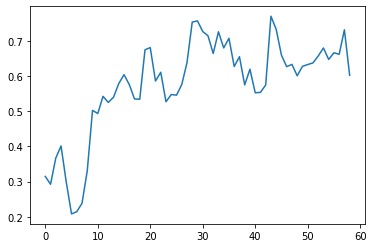

In [71]:
v = params[-1, :] - params[0, :]

sims = []
for i in range(len(params)-1):
    vp = params[i+1, :]-params[i, :]
    sims.append(torch.cosine_similarity(v, vp, dim=0).item())
plt.plot(sims)